# Surface profile and flow field

When putting a porous biomaterial in a thin liquid film, we observe a rim around the material. This rim looks differently from both the rest of the thin liquid film and the porous material. It seems that in this rim, there is less dye. It also seems that the liquid film thickness does not change monotonically near this rim. A snapshot of this rim is shown below:

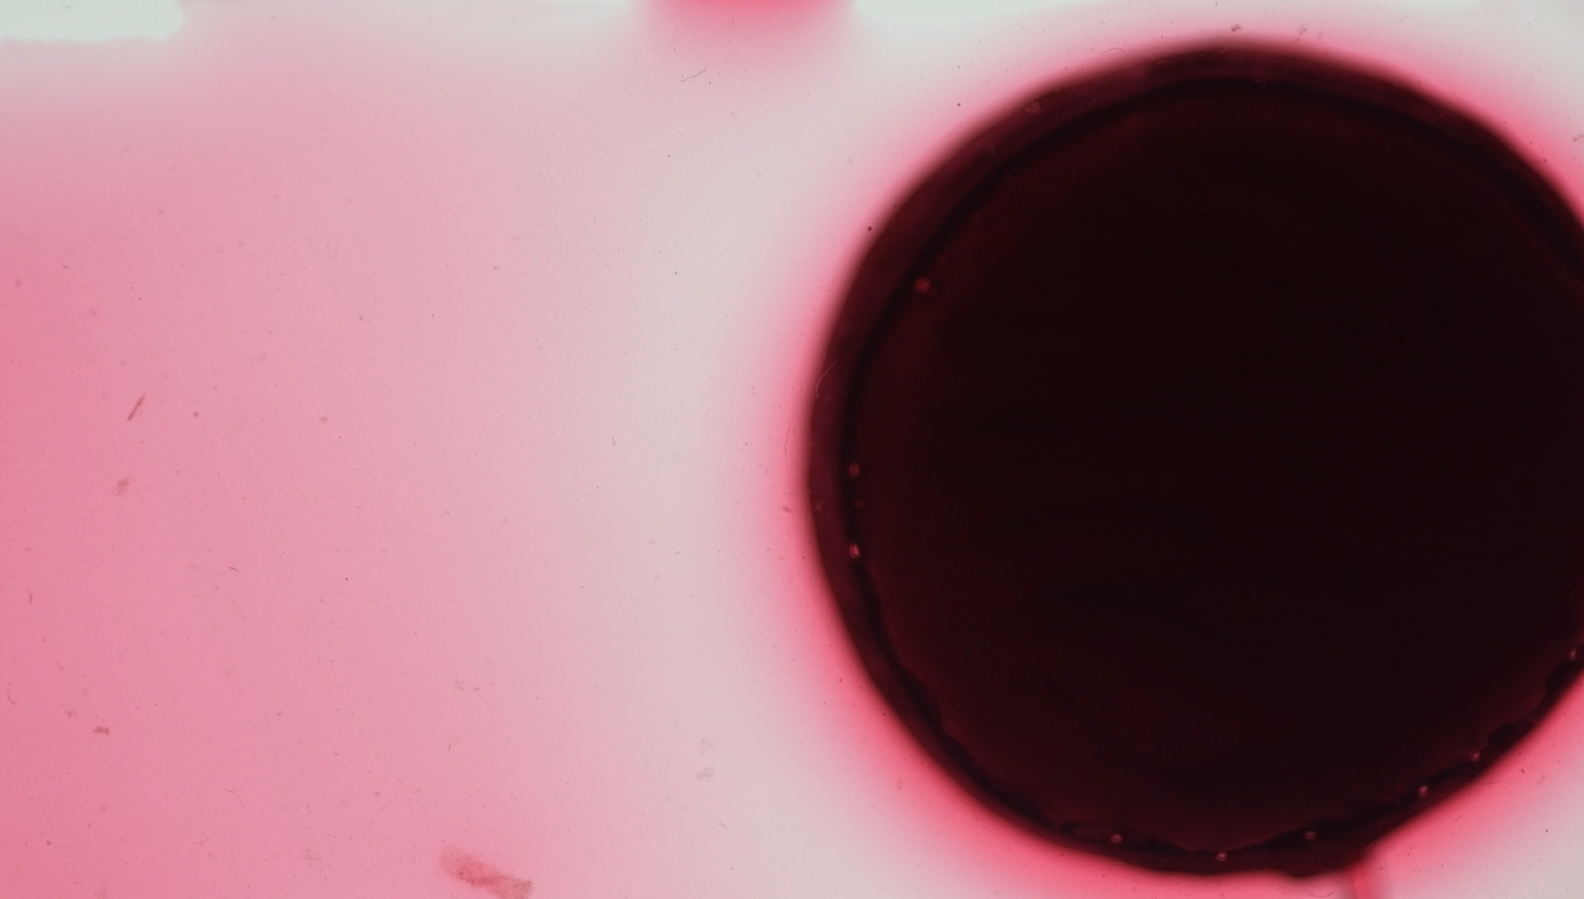

We want to understand the formation mechanism of this rim. Our hypothesis is that there is a dimple in the radial liquid surface profile, which leads to 
- thinner liquid film and in turn less amount of dye;
- curved surface that reflects light differently than flat one.
The two effects makes the rim particularly obvious to our eyes.

To test our hypotheses, I set up an experiment to measure the surface profile of the thin film around the rim. The surface measurement takes advantage of the [Keyence confocal displacement sensor](https://www.keyence.com/products/measure/laser-1d/cl-3000/) mounted on a motorized linear stage. At the same time, we use a Nikon DSLR camera to image the process of the rim formation, in the hope of extracting the flow field associated in this process. The setup is shown in the picture below.

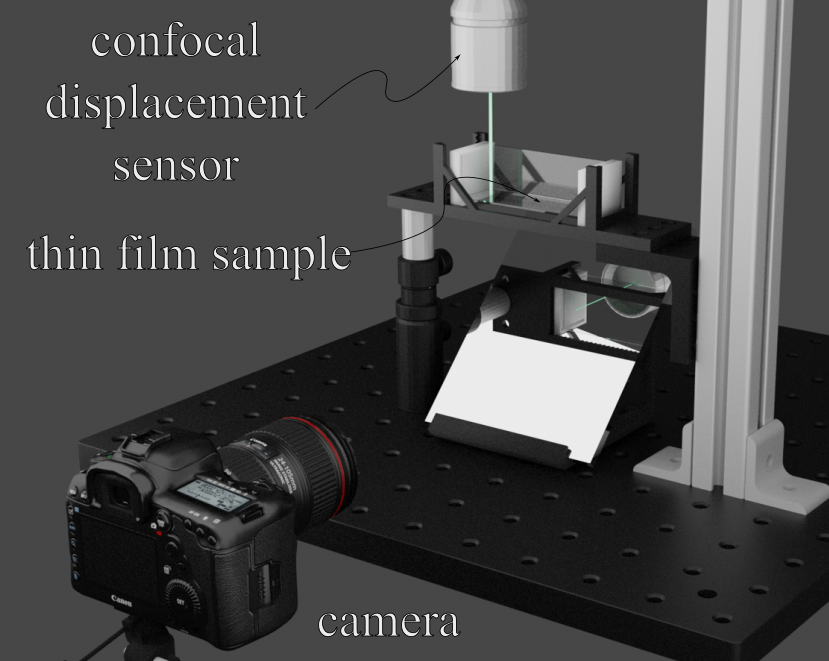

This measurement generates two raw data for each sample scan: 
- a text file of surface height vs. time (.csv);
- a bottom-view video of the scan process (.mov). 

Some postprocessing is required for the raw data:
- convert [surface height vs. time] to [surface height vs. horizontal position x];
- part of the surface height data is out of the liquid film region / out of the measurement range, which needs to be trimmed;
- synchronize the video with the scan, create a new video (like the [demo](https://drive.google.com/open?id=1LuXQMlca6CWQPx2JYWURytDooj1HmHBV&usp=drive_fs));
- measure the flow field using particle tracking velocimetry.

In this notebook, I demonstrate the postprocessing procedures. The expected outputs are:
- surface profile: a table of surface height vs. x, the file should correspond to the raw data file, but the surface height data should be trimmed and converted.
- scan demo: simultaneously display scan images and height results.

## 0 Packages and settings

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams['mathtext.fontset'] = 'stix'
from myimagelib.myImageLib import bestcolor, readdata
from scipy.signal import medfilt
from skimage import io
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt
from IPython.display import clear_output


## 1 Surface profile

In this section, we prepare the surface profile table from the raw .csv data.

### 1.1 Load surface height data

Text(0, 0.5, 'Surface height (mm)')

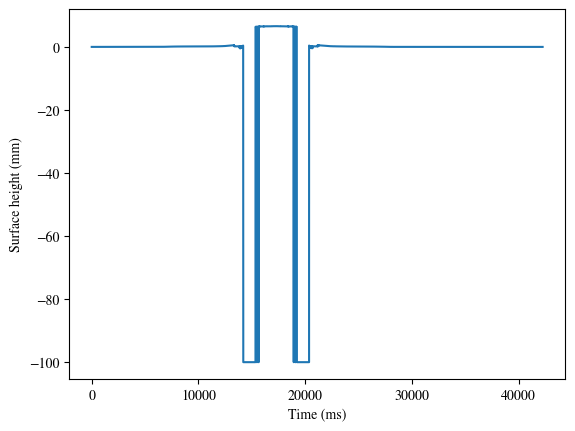

In [6]:
folder = r"E:\WPM\04292024"
filename = "beet_scan_1"
raw = pd.read_csv(os.path.join(folder, filename+".csv"), usecols=[1], skiprows=12)
plt.plot(raw)
plt.xlabel("Time (ms)")
plt.ylabel("Surface height (mm)")

The meaningful measurement is usually between 0 and 0.3 mm. The big rise or drop of the data is typically due to the distance being measured is out of range.

### 1.2 Trim the scan data

Trimming the raw scan data in Jupyter notebook is possible but slow because plots in Jupyter notebook does not allow free zooming and panning. Therefore, it is recommanded to use the script `examine_scan.py` view the raw scan data and to locate the "keyframes" of the scans in the raw data. Record the indices of those keyframes of multiple raw data files in one .csv file, and then we can trim the raw data with the keyframes information at once.

For example, we run the script and zoom in to see the following scan curve. We first identify the start and end points of the scan. Typically, starting point is where the height value just starts to deviate from 0, and the end point is the highest point of the smooth part. We usually scan back and forth for more time resolved data. In the keyframe recording, we differentiate the forward and backward scans by labels "f" and "b". Then, in each file, we typically have multiple scans of the same surface, we also label an integer on each scan to differentiate them. Lastly, we label the raw data file name to each entry, so we know where to perform the trimming.

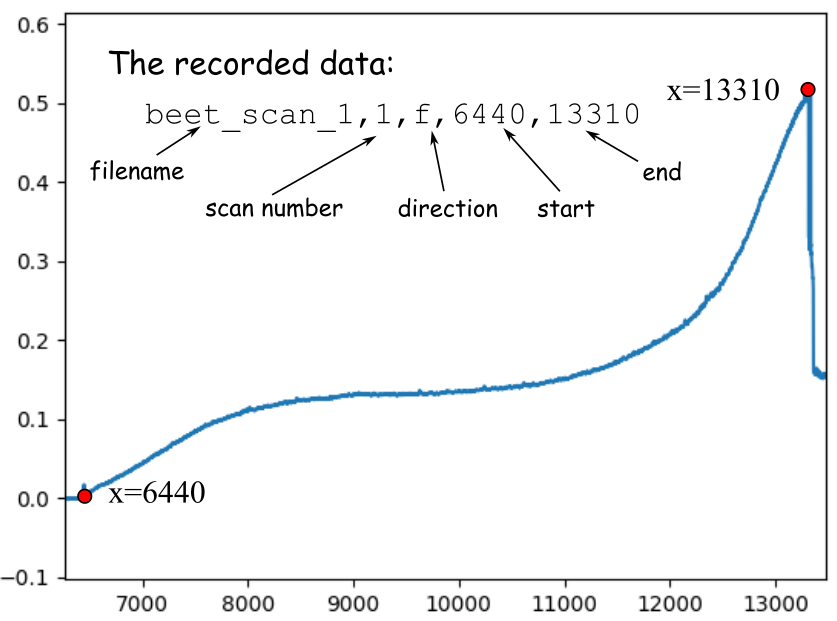


### 1.3 Convert to surface profile

With this keyframe labeling system, we can process multiple raw data files, and record the keyframes in a separate file, then use the numbers in this file to trim all the data in one run. This keyframe data file, "keyframes.csv", looks like this:

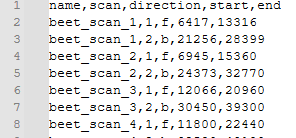

The following code extracts the surface profiles from raw scan data, based on the "keyframes.csv" data we just constructed. The surface profiles are saved as .csv file in the following format:

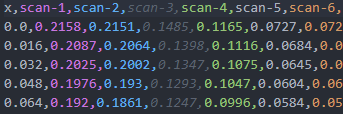

In [213]:
######## set parameters here ##########
data_folder = r"E:\WPM\08082024" # raw data folder
v = 16 # mm/s, I set it constant for now, but later this can be improved by measuring the speed for each specific scan
fps_data = 1000 # the frequency of the Keyence confocal sensor readout, typically 1000
offset = -0.00 # offset to correct the height data
#######################################

save_folder = os.path.join(data_folder, "surface_profile") # folder to save processed data
if os.path.exists(save_folder) == False:
    print("Save folder does not exist, creating ...")
    os.makedirs(save_folder)

keyframes = pd.read_csv(os.path.join(data_folder, "keyframes.csv"))

for name, namegroup in keyframes.groupby("name"):
    print("Processing {0} ...".format(name))
    surface = pd.read_csv(os.path.join(data_folder, "{}.csv".format(name)), usecols=[1], skiprows=12, names=["height"])
    surface["height"] = surface["height"] + offset
    for thickness, scans in namegroup.groupby("thickness"):
        scans_list = []
        t0 = scans.iloc[0]["start"]
        for num, i in scans.iterrows():
            # print("Processing file {0}: scan {1:d}".format(name, i.scan))
            scan = surface[np.round(i.start).astype("int"): np.round(i.end).astype("int")].copy()
            if i.direction == "f":
                scan["x"] = np.flip(np.arange(len(scan))) / fps_data * v
            else:
                scan["x"] = np.arange(len(scan)) / fps_data * v 
            scan.sort_values(by=["x"], inplace=True)
            scans_list.append(scan.set_index("x").rename(columns={"height": "{:.1f}".format(((i.start+i.end)/2 - t0)/fps_data)}))
        print("Writing {0}_{1}.csv".format(name, thickness))
        pd.concat(scans_list, axis=1).dropna().to_csv(os.path.join(save_folder, "{0}_{1}.csv".format(name, thickness)))

Processing beet_juice_1 ...
Writing beet_juice_1_1.csv
Writing beet_juice_1_2.csv
Writing beet_juice_1_3.csv


### 1.4 Plot the surface profiles

With the organized surface profiles, we can plot them easily. The most informative way of plotting the surface profiles I found is to plot all the repeated scans in one axis. This way we can observe the temporal evolution of the film. 

In [317]:
folder = r"E:\WPM\08082024\surface_profile"
l = readdata(folder, "csv")
for num, i in l.iterrows():
    df = pd.read_csv(i.Dir).set_index("x")
    count = 0
    fig, ax = plt.subplots(figsize=(4.5,2.5), dpi=300)
    cmap = plt.get_cmap("viridis")
    tmax = float(df.columns[-1])
    for kw in df:
        if count % 2 == 1:
            ax.plot(df.index, df[kw], color=cmap(float(kw)/tmax), lw=1)
        count += 1

    ax.set_xlim([0, df.index[-1]])
    ax.set_ylim([0, df.max().max()])
    # generate a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=tmax))
    plt.colorbar(sm, ax=ax, label="Time (s)")
    ax.set_xlabel("Distance, $x$ (mm)")
    ax.set_ylabel("Surface height, $h$ (mm)")
    plt.tight_layout()
    fig.savefig(os.path.join(folder, i.Name+".jpg"))
    plt.close(fig)

We can also put films of different thicknesses together, which allows us to assess the thickness effect.

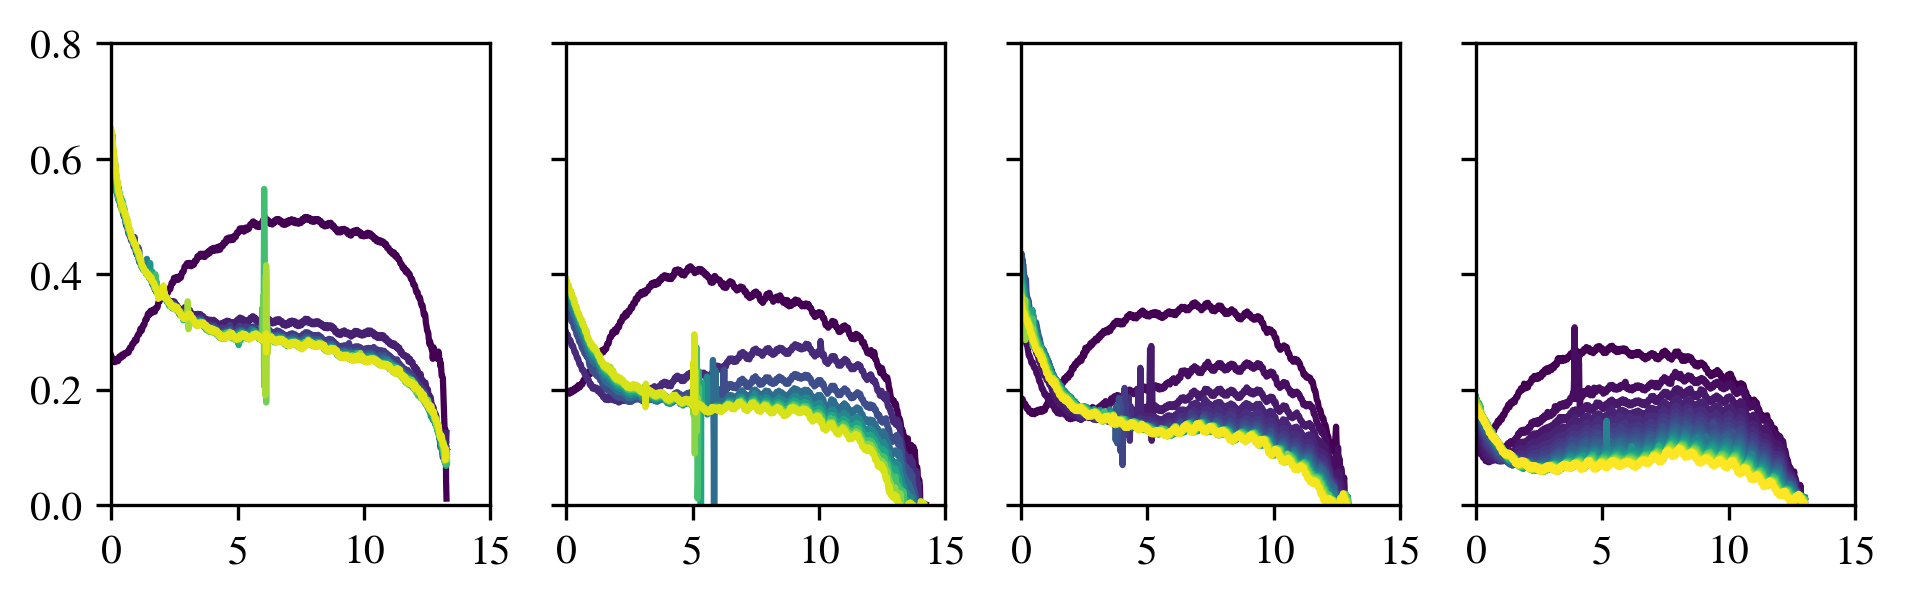

In [70]:
folder = r"G:\My Drive\Research projects\WPM\Data\06212024\surface_profile"
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(7.5,2), dpi=300)
for j in range(4):
    df = pd.read_csv(os.path.join(folder, "PB_S10_trial1_{:d}.csv".format(j+1))).set_index("x")
    cmap = plt.get_cmap("viridis", df.shape[1])
    i = 0
    for scan in df:
        if i % 2 == 0:
            # ax[j].plot(df.index, gaussian_filter1d(df[scan], 5), color=cmap(i), label="{:d} s".format(i*2))
            ax[j].plot(df.index, df[scan], color=cmap(i), label="{:d} s".format(i*2))
            ax[j].set_xlim([0,15])
            ax[j].set_ylim([0,0.8])
        i += 1

### 1.5 Process the scan data

#### 1.5.1 Smoothing with FFT

The stepping motor setup greatly enhanced the temporal resolution of the scan. However, the constant vibration is making the surface profile noisy. In this section, I implement a frequency filter to smooth the scan data. 

(-0.1, 0.8)

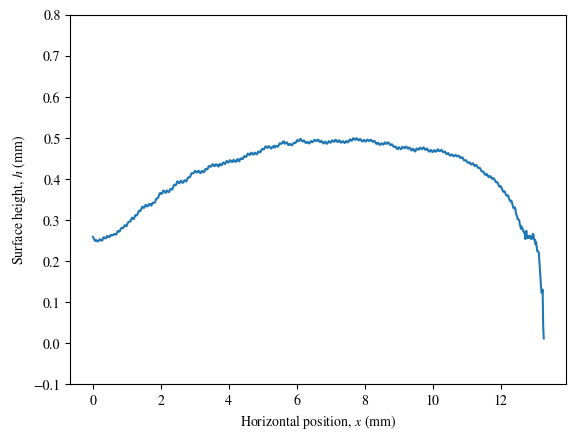

In [96]:
folder = r"G:\My Drive\Research projects\WPM\Data\06212024"
df = pd.read_csv(os.path.join(folder, "surface_profile", "PB_S10_trial1_1.csv")).set_index("x")
plt.plot(df.index, df["scan-1"])
plt.xlabel("Horizontal position, $x$ (mm)")
plt.ylabel("Surface height, $h$ (mm)")
plt.ylim([-0.1, 0.8])

In [128]:
def freq_filter(signal, cutoff):
    """
    signal is a two-row array with t and y. Cutoff is set in unit of 1/[t].
    """
    t, y = signal[0], signal[1]
    # sampling frequency
    fs = len(t) / t.max()

    # compute fft
    fft_signal = np.fft.fft(y)
    fft_freq = np.fft.fftfreq(len(t), 1/fs)

    # apply frequency filter
    fft_signal_filtered = fft_signal.copy()
    fft_signal_filtered[np.abs(fft_freq) > cutoff] = 0

    # compute inverse fft
    filtered_signal = np.fft.ifft(fft_signal_filtered).real

    return np.array([t, filtered_signal])


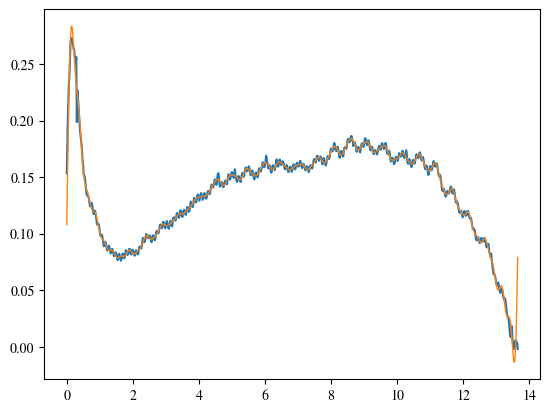

In [129]:
signal = np.array([df.index, df["scan-7"]])
cutoff = 4
filtered = freq_filter(signal, cutoff)
plt.plot(signal[0], signal[1])
plt.plot(filtered[0], filtered[1], lw=1)

(0.0, 0.8)

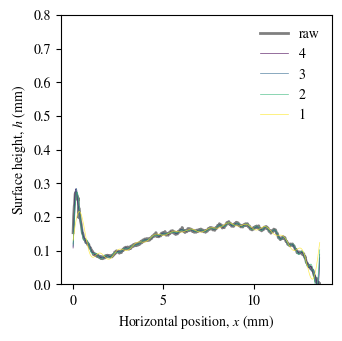

In [130]:
# try various cutoff frequencies
plt.figure(figsize=(3.5,3.5))
plt.plot(signal[0], signal[1], color="black", lw=2, alpha=.5, label="raw")
co_list = np.flip(np.arange(1, 5))
cmap = plt.get_cmap("viridis", len(co_list))
i = 0
for cutoff in co_list:
    filtered = freq_filter(signal, cutoff)
    plt.plot(filtered[0], filtered[1], color=cmap(i), lw=.5, alpha=.8, label=cutoff)
    i += 1
plt.legend(frameon=False)
plt.xlabel("Horizontal position, $x$ (mm)")
plt.ylabel("Surface height, $h$ (mm)")
plt.ylim([0, 0.8])

#### 1.5.2 Smoothing with butterworth

In [46]:
def butterworth_filter(signal, cutoff):

    t, y = signal[0], signal[1]
    fs =  len(t) / t.max()

    order = 3  # Order of the filter
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalized cutoff frequency

    # Butterworth filter design
    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    # Step 3: Apply the Butterworth filter to the signal
    filtered_signal = filtfilt(b, a, y)

    return np.array([t, filtered_signal])

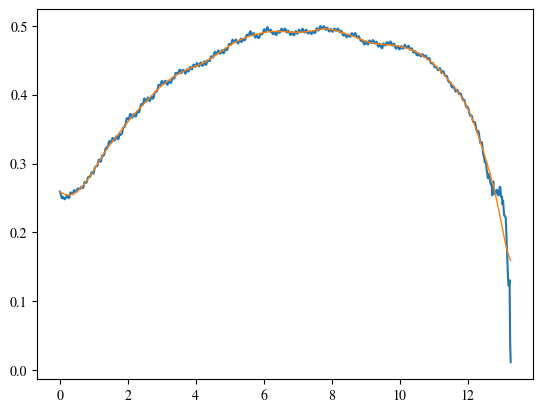

In [187]:
plt.figure()
signal = np.array([df.index, df["scan-1"]])
cutoff = 1
filtered = butterworth_filter(signal, cutoff)
plt.plot(signal[0], signal[1])
plt.plot(filtered[0], filtered[1], lw=1)

(0.0, 0.7)

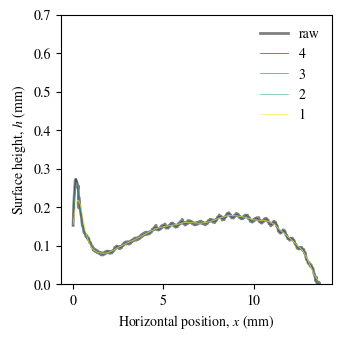

In [123]:
# try various cutoff frequencies
plt.figure(figsize=(3.5,3.5))
signal = np.array([df.index, df["scan-7"]])
plt.plot(signal[0], signal[1], color="black", lw=2, alpha=.5, label="raw")
co_list = np.flip(np.arange(1, 5))
cmap = plt.get_cmap("viridis", len(co_list))
i = 0
for cutoff in co_list:
    filtered = butterworth_filter(signal, cutoff)
    plt.plot(filtered[0], filtered[1], color=cmap(i), lw=.5, alpha=.8, label=cutoff)
    i += 1
plt.legend(frameon=False)
plt.xlabel("Horizontal position, $x$ (mm)")
plt.ylabel("Surface height, $h$ (mm)")
plt.ylim([0, 0.7])

(0.0, 0.8)

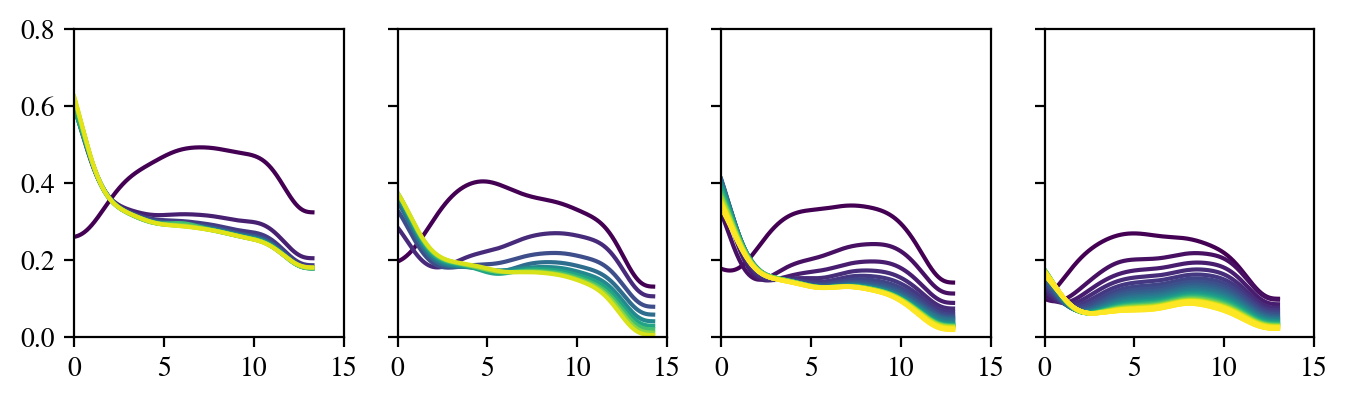

In [195]:
# plot all curves with butterworth smoothing

folder = r"G:\My Drive\Research projects\WPM\Data\06212024\surface_profile"
cutoff = .3
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(8,2), dpi=200)
for j in range(4):
    df = pd.read_csv(os.path.join(folder, "PB_S10_trial1_{:d}.csv".format(j+1))).set_index("x")
    cmap = plt.get_cmap("viridis", min(df.shape[1], max_curve))
    i = 0
    for kw in df:
        if i % 2 == 0:
            y = df[kw]
            signal = np.array([y.index, y])
            x, s = butterworth_filter(signal, cutoff)
            s = pd.DataFrame(data={"s": s}, index=x)
            ax[j].plot(s.index, s, color=cmap(i), label="{:d} s".format(i*2))
        i += 1
ax[0].set_xlim([0, 15])
ax[0].set_ylim([0, 0.8])

## 2 Display surface scan and video simultaneously

Making a video out of the surface height data and play together with the bottom-view video help to check the surface height data validity, and also help in understanding the surface height data. In this section, we use the processed surface profile data and the bottom view video to generate the simultaneous display, as shown below:

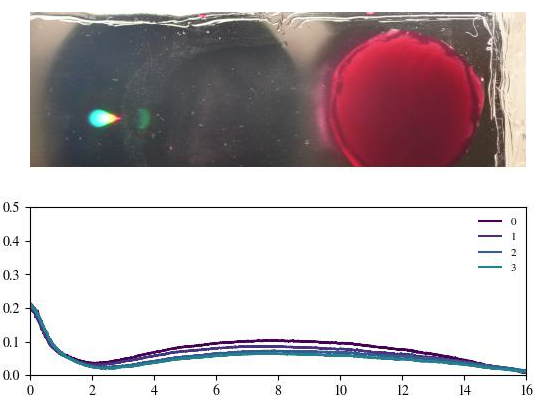

### 2.1 Synchronize raw scan data and video

Open video in MPC and find the first and last moments when laser touches the liquid film. For example, for the file 04292024/beet_scan4_3.MOV, first moment is 00:20.887 and last moment is 02:39.425. In the raw scan data, these two times corresponds to the beginning of the first scan and then end of the last scan, which can be read from the keyframes.csv file: 11797 and 151029. 

In a typical experiment, I start imaging first and then the scan data recording. So we can use linear extrapolation to get the time in the video that corresponds to the starting point of the scan data. 

In [8]:
####### set parameters here ########
v_1 = 6.843
v_2 = 361.468
s_1 = 8181
s_2 = 362785
####################################
v_0 = v_1 - s_1 * (v_2 - v_1) / (s_2 - s_1)
print("Scan data recording starts at {:.3f} s in the video.".format(v_0))

Scan data recording starts at -1.338 s in the video.


### 2.2 Generate images

Use the v_0 calculated in the previous section to register surface scan data and the video. Generate synchronized images. 

KeyError: 'scan-25'

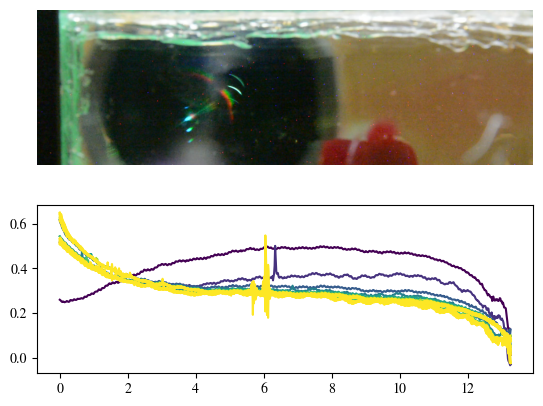

In [10]:
####### set parameters here ###########
data_folder = r"E:\WPM\06212024"
file_name = "PB_S10_trial1"
interval = 1 # save image every certain frames
fps_data = 1000 # the frequency of the Keyence confocal sensor readout, typically 1000
#######################################

cap = cv2.VideoCapture(os.path.join(data_folder, file_name + ".MOV"))
data = pd.read_csv(os.path.join(data_folder, "surface_profile", file_name + "_1.csv"))
keyframes = pd.read_csv(os.path.join(data_folder, "keyframes.csv"))
keyframes = keyframes.loc[keyframes["name"]==file_name].reset_index()

save_folder = os.path.join(data_folder, "scan_demo", file_name)
if os.path.exists(save_folder) == False:
    print("Save folder does not exist, creating ...")
    os.makedirs(save_folder)

cmap = plt.get_cmap("viridis", 8)
datalen = len(data)
i = 0
j = 0
fps = 30

while True:
    ret, frame = cap.read() 
    i += 1
    
    # break the loop if no image can be read any more
    if ret == False:
        break
    
    # generate image at interval
    if i % interval != 0:
        continue
    # convert imagae to RGB to use matplotlib.imshow
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(ncols=1, nrows=2, dpi=100)
    ax[0].imshow(frame[200:800, :])
    ax[0].axis("off")
    step = (i / fps - v_0) * fps_data

    # plot all the past full curves
    for k in range(j):
        ax[1].plot(data.x, data["scan-{:d}".format(k+1)], color=cmap(k), label=k)

    # plot the partial curve
    fraction = (step - keyframes.at[j, "start"]) / (keyframes.at[j, "end"] - keyframes.at[j, "start"])
    if fraction > 0:
        if keyframes.at[j, "direction"] == "f":
            ax[1].plot(data.loc[int(datalen*(1-fraction)):, "x"], data.loc[int(datalen*(1-fraction)):, "scan-{:d}".format(j+1)], color=cmap(j), label=j)
        else:
            ax[1].plot(data.loc[:int(datalen*fraction), "x"], data.loc[:int(datalen*fraction), "scan-{:d}".format(j+1)], color=cmap(j), label=j)
        plt.legend(fontsize=8, frameon=False)

    # set axis limits and save plots
    ax[1].set_xlim([0, 16])
    ax[1].set_ylim([0, 0.5])
    plt.savefig(os.path.join(save_folder, "{:04d}.jpg".format(i)))
    plt.close()

    # if the step in scan data is out of the thin film regime, switch to the next one
    if step >= keyframes.at[j, "end"]:
        j += 1
    # if j >= 8:
    #     break
    

## 3 Flow field

Use Tracker to track a few particles manually.

### 3.1 Velocity over time at certain points

Assume that in the proxy of the beet, the flow velocity is independent of position and is only a function of time. Note that this cannot be true, because we know the film is not uniform in thickness. If velocity is constant everywhere, fluid continuity cannot be satisfied. However, the flow rate change here is more drastic in time than in space, 

In [ ]:
flow = pd.read_csv(r"E:\WPM\04292024\flow_field_hand_track\beet_scan4_4_particle.txt", skiprows=2, sep=",").set_index("t")
flow.head()

x      y  x.1  y.1  x.2  y.2  x.3  y.3  Unnamed: 9
t                                                            
5.339  6.049  0.356  NaN  NaN  NaN  NaN  NaN  NaN         NaN
5.372    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN         NaN
5.405    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN         NaN
5.439    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN         NaN
5.472    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN         NaN

In [ ]:
vkey_list = []
for key in flow:
    if "x" in key:
        vkey = key.replace("x", "v")
        vkey_list.append(vkey)
        flow[vkey] = np.nan
        flow.loc[flow[key].dropna().index, vkey] = (flow[key].dropna().diff()) / (flow[key].dropna().index.diff().values)

In [ ]:
v_mean = flow[vkey_list].mean(axis=1).dropna()

Text(0, 0.5, 'Flow velocity, v (mm/s)')

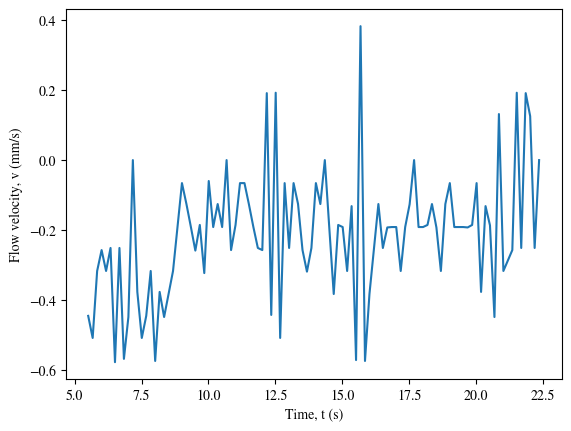

In [ ]:
plt.plot(v_mean)
plt.xlabel("Time, t (s)")
plt.ylabel("Flow velocity, v (mm/s)")

In [ ]:
v_mean.abs().to_frame("Velocity").to_csv(r"E:\WPM\04292024\flow_field_hand_track\beet_scan4_4_flow-time.csv")

Plot the velocity over time for the four scans.

In [2]:
folder = r"E:\WPM\04292024\flow_field_hand_track"
df_list = []
for i in range(4):
    df = pd.read_csv(os.path.join(folder, "beet_scan4_{:d}_flow-time.csv".format(i+1))).rename(columns={"Velocity": "v{:d}".format(i)})
    df["t"] -= df["t"].min()
    df_list.append(df.sort_values("t").set_index("t"))
dfall = pd.concat(df_list, names=["v1", "v2", "v3", "v4"], axis=1)

In [3]:
df.sort_values(by="t")

t        v3
0    0.000  0.445783
1    0.167  0.508982
2    0.334  0.317365
3    0.501  0.257485
4    0.668  0.317365
..     ...       ...
94  16.183  0.251497
95  16.350  0.191617
96  16.517  0.125749
97  16.684  0.251497
98  16.851  0.000000

[99 rows x 2 columns]

<Axes: >

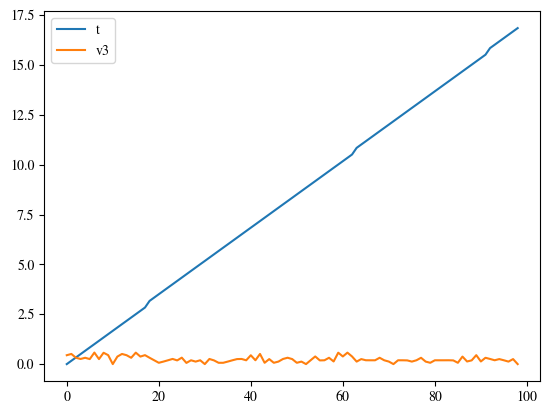

In [4]:
df.sort_values(by="t").plot()

(0.0, 6.0)

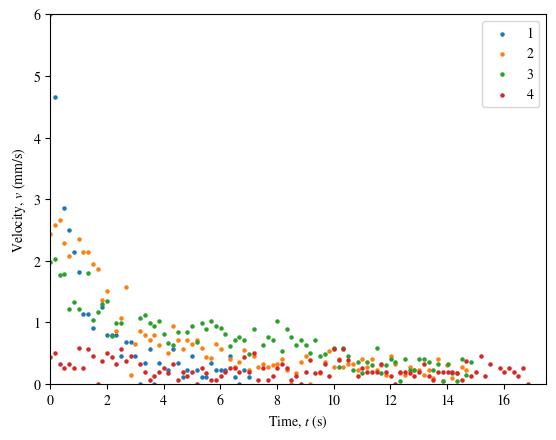

In [ ]:
for key in dfall:
    plt.scatter(dfall.index, dfall[key], s=5)
plt.legend([1,2,3,4])
plt.xlabel("Time, $t$ (s)")
plt.ylabel("Velocity, $v$ (mm/s)")
plt.xlim([0,17.5])
plt.ylim([0,6])

(0.0, 3.0)

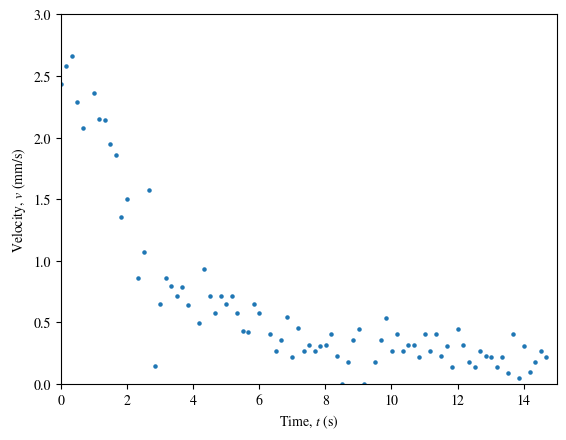

In [9]:
plt.scatter(dfall.index, dfall["v1"], s=5)
plt.xlabel("Time, $t$ (s)")
plt.ylabel("Velocity, $v$ (mm/s)")
plt.xlim([0, 15])
plt.ylim([0, 3])

In [55]:
v1_sm+std

0
t               
0.000        NaN
0.167        NaN
0.333        NaN
0.500        NaN
0.667   2.311723
...          ...
14.014  0.461144
14.181  0.254626
14.347  0.330157
14.514  0.381036
14.681  0.304737

[84 rows x 1 columns]

In [61]:
v1_sm.values.shape

(84, 1)

(0.0, 3.0)

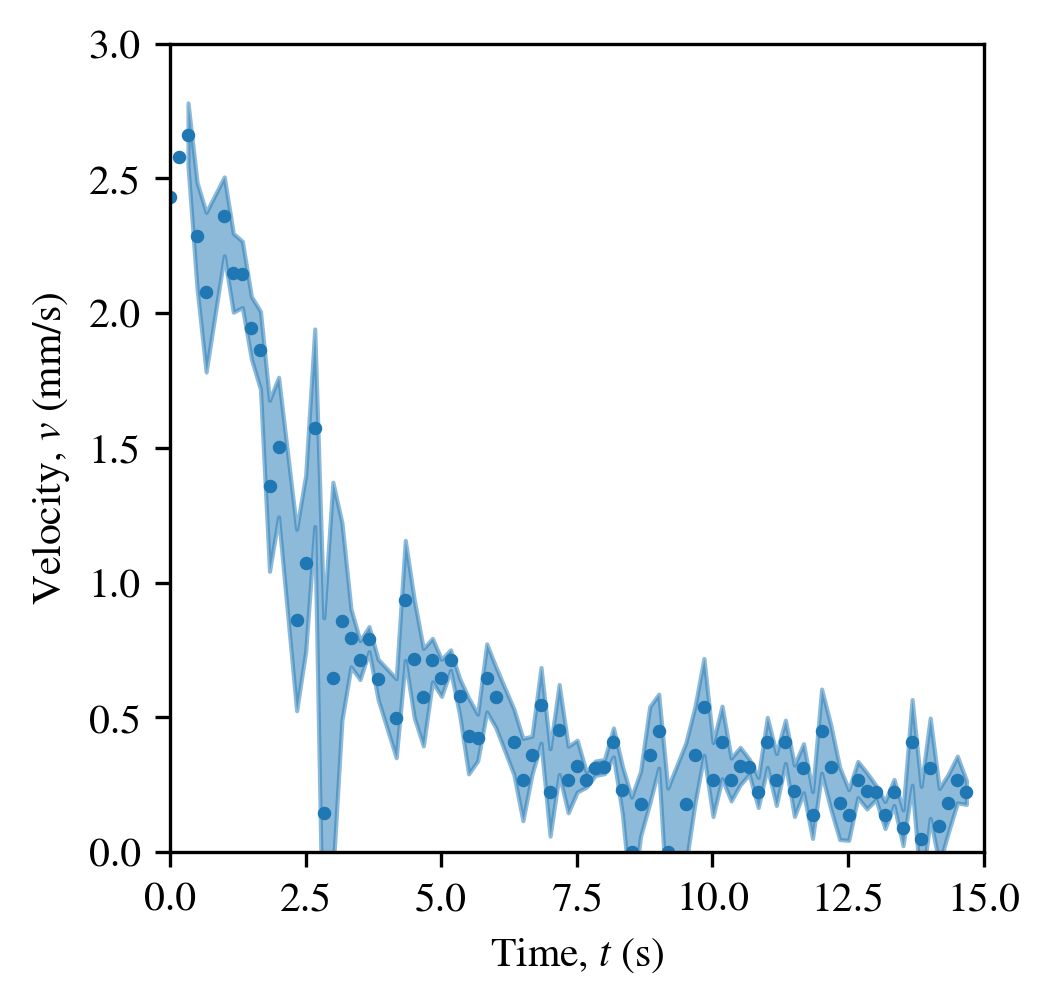

In [74]:
plt.figure(figsize=(3.5, 3.5), dpi=300)
v1 = dfall["v1"].dropna().sort_index()
v = v1.values
t = v1.index
v_sm = medfilt(v, 1)
v1_sm = pd.DataFrame(data=v_sm, index=t)
std = v1_sm.rolling(window=3).std()
plt.scatter(v1_sm.index, v1_sm, s=5)
plt.fill_between(v1_sm.index, np.array(v1_sm-std).squeeze(), np.array(v1_sm+std).squeeze(), color=bestcolor(0), alpha=0.5)
plt.xlabel("Time, $t$ (s)")
plt.ylabel("Velocity, $v$ (mm/s)")
plt.xlim([0, 15])
plt.ylim([0, 3])

### 3.2 Spatial variation

## 4 Surface profile analysis

With the more time-resolved surface profile measurements, we gain better understanding of the dimple formation. To obtain more quantitative understanding, we want to analyze the surface profiles by extracting characteristic quantities at various time. Specifically, we are going to look at how film thickness and curvature change over time.

### 4.1 Thickness

Use the mean surface height as the characteristic thickness. 

In [18]:
# load profile data
folder = r"G:\My Drive\Research projects\WPM\Data\06212024"
df = pd.read_csv(os.path.join(folder, "surface_profile", "PB_S10_trial1_4.csv")).set_index("x")

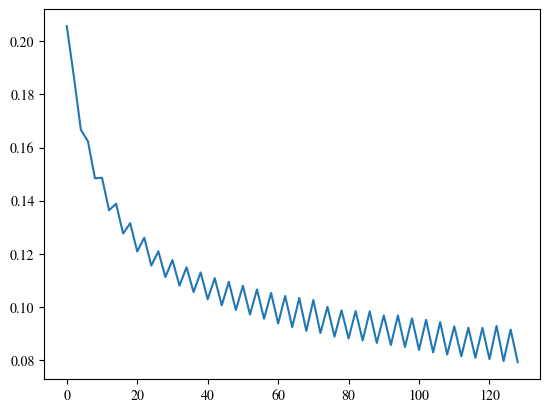

In [20]:
thickness_list = []
for kw in df:
    thickness_list.append(df[kw].mean())
plt.plot(np.arange(len(thickness_list))*2, thickness_list)

(0.0, 0.5)

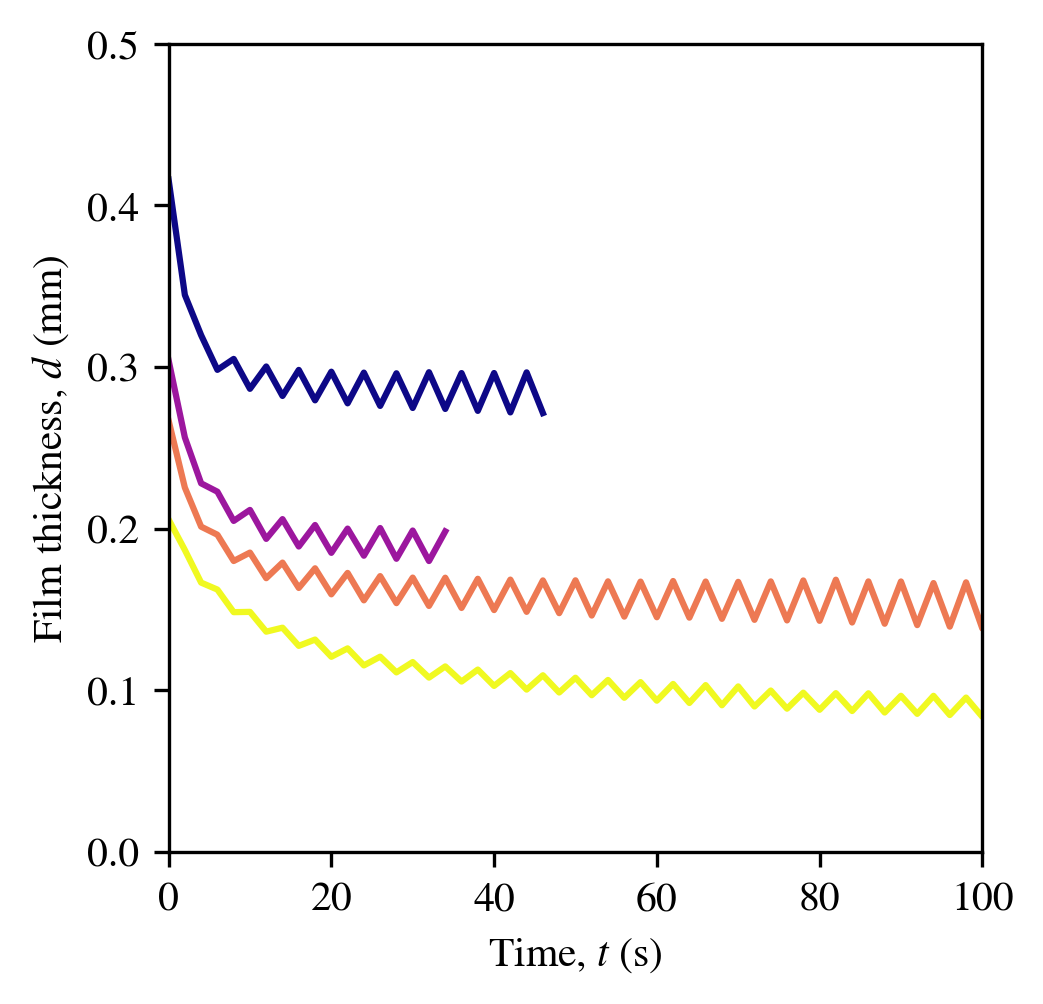

In [22]:
# plot multiple initial thickness
folder = r"G:\My Drive\Research projects\WPM\Data\06212024"
cmap = plt.get_cmap("plasma", 4)

plt.figure(figsize=(3.5,3.5), dpi=300)
for i in range(4):
    df = pd.read_csv(os.path.join(folder, "surface_profile", "PB_S10_trial1_{:d}.csv".format(i+1))).set_index("x")
    thickness_list = []
    for kw in df:
        thickness_list.append(df[kw].mean())
    plt.plot(np.arange(len(thickness_list))*2, thickness_list, color=cmap(i))
plt.xlabel("Time, $t$ (s)")
plt.ylabel("Film thickness, $d$ (mm)")
plt.xlim([0, 100])
plt.ylim([0, 0.5])

### 4.2 Curvature



#### 4.2.1 Second derivative

For a 2D curve defined as $y=f(x)$, the radius of curvature at point $x$ can be calculated as

$$
R(x) = (1 + f'^2)|f''|,
$$

where $f'=dy/dx$ and $f'' = d^2y/dx^2$ are the first and second derivatives of $y$ with respect to $x$, respectively. 

We can calculate the derivatives numerically from the discrete experimental data. The most straightforward method is using the central difference scheme:

$$
f' = \frac{f(x+h) - f(x-h)}{2h},\\
f'' = \frac{f'(x+h) - f'(x-h)}{2h}  = \frac{f(x+h) - 2f(x) + f(x-h)}{h^2}.
$$

Let's see what result comes out.

### 4.3 Dimple analysis: detection and lifetime

#### 4.3.1 Dimple detection

In this section, we develope an algorithm to detect dimple from provided 1D signal automatically. For each surface_profile data (repeated scans over the same surface), we first check whether dimple exists by detecting local minimum in the signal. If dimple exists, record (time, dimplex, dimpley, apexx, apexy) of the dimple and the corresponding apex. If not, record (time, nan, nan, nan, nan) instead.

In [328]:
folder = r"E:\WPM\08082024\surface_profile"
dimple_folder = r"E:\WPM\08082024\dimple_detection"
# make dimple folder
if os.path.exists(dimple_folder) == False:
    print("Dimple folder does not exist, creating ...")
    os.makedirs(dimple_folder)
l = readdata(folder, "csv")
exclude = 30

for num, i in l.iterrows():
    df = pd.read_csv(i.Dir).set_index("x")
    # check if local minima exist in all columns
    minima_list = []
    maxima_list = []
    t_list = []
    tmax = float(df.columns[-1])
    cmap = plt.get_cmap("viridis")
    j = 0
    fig, ax = plt.subplots(figsize=(2,1), dpi=300)
    for kw in df:
        if j % 2 == 1:
            t = float(kw)
            t_list.append(t)
            x, y = df.index, df[kw].values
            # plt.plot(x, y, color=cmap(float(kw)/tmax))
            # smooth the curve
            # Design a Butterworth low-pass filter
            order = 4
            cutoff_frequency = 0.02  # Normalized cutoff frequency (0 to 0.5)
            b, a = butter(order, cutoff_frequency, btype='low', analog=False)
            # Apply the filter to the data
            y_filtered = filtfilt(b, a, y)
            # Find local minima in the filtered data, exclude the first last points
            
            minima_indices = argrelextrema(y_filtered[exclude:-exclude], np.less)
            maxima_indices = argrelextrema(y_filtered[exclude:-exclude], np.greater)
            # Plot the minima
            if len(minima_indices[0]) > 0:
                ax.plot(t, y_filtered[minima_indices[0][0]+exclude], 'ro', markersize=2)
                minima_list.append(y[int(minima_indices[0][0]+exclude)])
            else:
                minima_list.append(np.nan)
            if len(maxima_indices[0]) > 0:
                ax.plot(t, y_filtered[maxima_indices[0][0]+exclude], 'go', markersize=2)            
                maxima_list.append(y[maxima_indices[0][0]+exclude])
            else:
                maxima_list.append(np.nan)
        j += 1
    # save dimple data to file
    dimple = pd.DataFrame(data={"t": t_list, "minima": minima_list, "maxima": maxima_list})
    dimple.to_csv(os.path.join(dimple_folder, i.Name+".csv"), index=False)
    ax.set_xlim([0, tmax])
    ax.set_ylim([0, .3])
    ax.legend(["Minima", "Maxima"], frameon=False, fontsize=5)
    # ax.set_xlabel("Time, $t$ (s)")
    # ax.set_ylabel("Surface height, $h$ (mm)")
    plt.tight_layout()
    fig.savefig(os.path.join(dimple_folder, "dimple_"+i.Name+".pdf"), bbox_inches="tight")
    plt.close(fig)

#### 4.3.2 Dimple lifetime

Ideally, we want to use the time it takes for the dimple detection result to transition from numbers to nan, to evaluate dimple lifetime. However, we observe from the data that such transition is rare. Instead, most local minima exist through out the 100-second measurement, despite that these local minima are almost a flat line. This makes using the existence of local minima as the indicator of dimple a bad idea. 

A closer look at the data suggests that we can use the height ratio between maxima and minima as the indicator of dimple (or more precisely, the appearance of visual fringe). The reason is that to observe the fringe, it requires sufficient contrast in the dimple region as opposed to the rest of the film. 

In this section, we measure this ratio and decide a threshold, which will be used to characterize the lifetime of dimple.

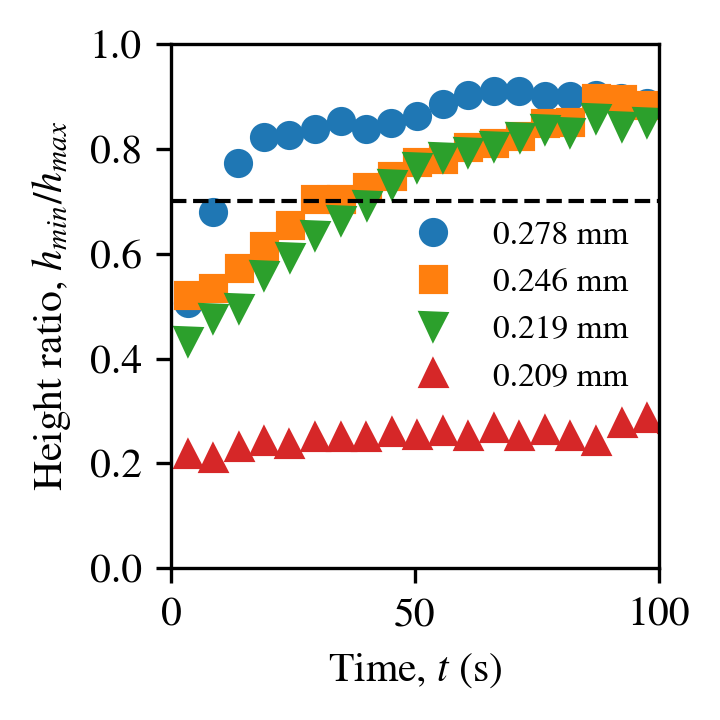

In [315]:
# read dimple data
# initial thickness for 0808 / 3-2 3-3 3-4 3-5
initial_thickness = [0.278, 0.246, 0.219, 0.209]
dimple_folder = r"E:\WPM\08082024\dimple_detection"
l = ["beet_juice_3_2.csv", "beet_juice_3_3.csv", "beet_juice_3_4.csv", "beet_juice_3_5.csv"]
markers = ["o", "s", "v", "^"]
fig, ax = plt.subplots(figsize=(2.5,2.5), dpi=300)
cmap = plt.get_cmap("tab10")
for i in range(4):
    dimple = pd.read_csv(os.path.join(dimple_folder, l[i]))
    ax.plot(dimple["t"], dimple["minima"] / dimple["maxima"], ls="", marker=markers[i],
    color=cmap(i), label="{:.3f} mm".format(initial_thickness[i]))
ax.legend(frameon=False, fontsize=8)
ax.set_xlabel("Time, $t$ (s)")
ax.set_ylabel("Height ratio, $h_{min}/h_{max}$")
ax.set_xlim([0, 100])
ax.set_ylim([0, 1])
# plot a line at y = 0.7
ax.axhline(0.7, color="black", ls="--", lw=1)
# tight layout
plt.tight_layout()



In [289]:
# find the time when the height ratio is 0.7
t_list = []
for i in range(4):
    dimple = pd.read_csv(os.path.join(dimple_folder, l[i]))
    # handle the case when dimple["maxima"] > 0.7 is never satisfied
    ts = dimple.loc[dimple["minima"] / dimple["maxima"] > 0.7, "t"]
    if len(ts) != 0:
        t = ts.iloc[0]
    else:
        t = 100
    t_list.append(t)
    print("Initial thickness {:.3f} mm: dimple time {:.3f} s".format(initial_thickness[i], t))

Initial thickness 0.278 mm: dimple time 13.800 s
Initial thickness 0.246 mm: dimple time 29.600 s
Initial thickness 0.219 mm: dimple time 45.300 s
Initial thickness 0.209 mm: dimple time 100.000 s


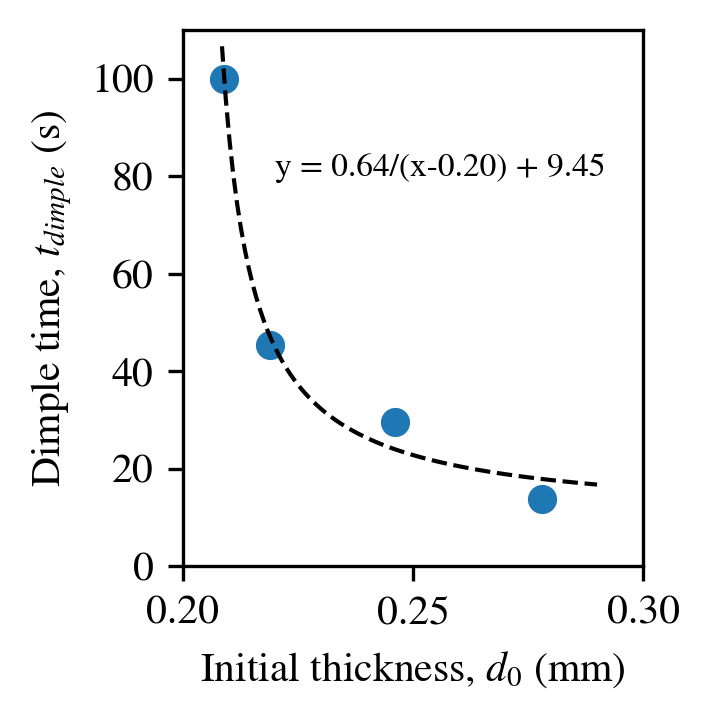

In [322]:
# plot the dimple time vs initial thickness
plt.figure(figsize=(2.5,2.5), dpi=300)
plt.plot(initial_thickness, t_list, ls="", marker="o")
plt.xlabel("Initial thickness, $d_0$ (mm)")
plt.ylabel("Dimple time, $t_{dimple}$ (s)")
plt.xlim([0.2, 0.3])
plt.ylim([0, 110])
# fit an inverse linear model
from scipy.optimize import curve_fit
def inverse_linear(x, a, b, c):
    return a/(x-b) + c

popt, pcov = curve_fit(inverse_linear, initial_thickness, t_list, [1,.2,1])
x = np.linspace(0.2085, 0.29, 100)
y = inverse_linear(x, *popt)
plt.plot(x, y, color="black", ls="--", lw=1)
plt.text(0.22, 80, "y = {:.2f}/(x-{:.2f}) + {:.2f}".format(*popt), fontsize=8)
plt.tight_layout()


In [298]:
t_list

[13.8, 29.6, 45.3, 100]

In [264]:
data[126817:128180].mean()

height    0.277589
dtype: float64

In [265]:
data[247181:248544].mean()

height    0.245954
dtype: float64

In [262]:
data[362332:363675].mean()

height    0.21896
dtype: float64

In [263]:
data[477467:478815].mean()

height    0.208841
dtype: float64

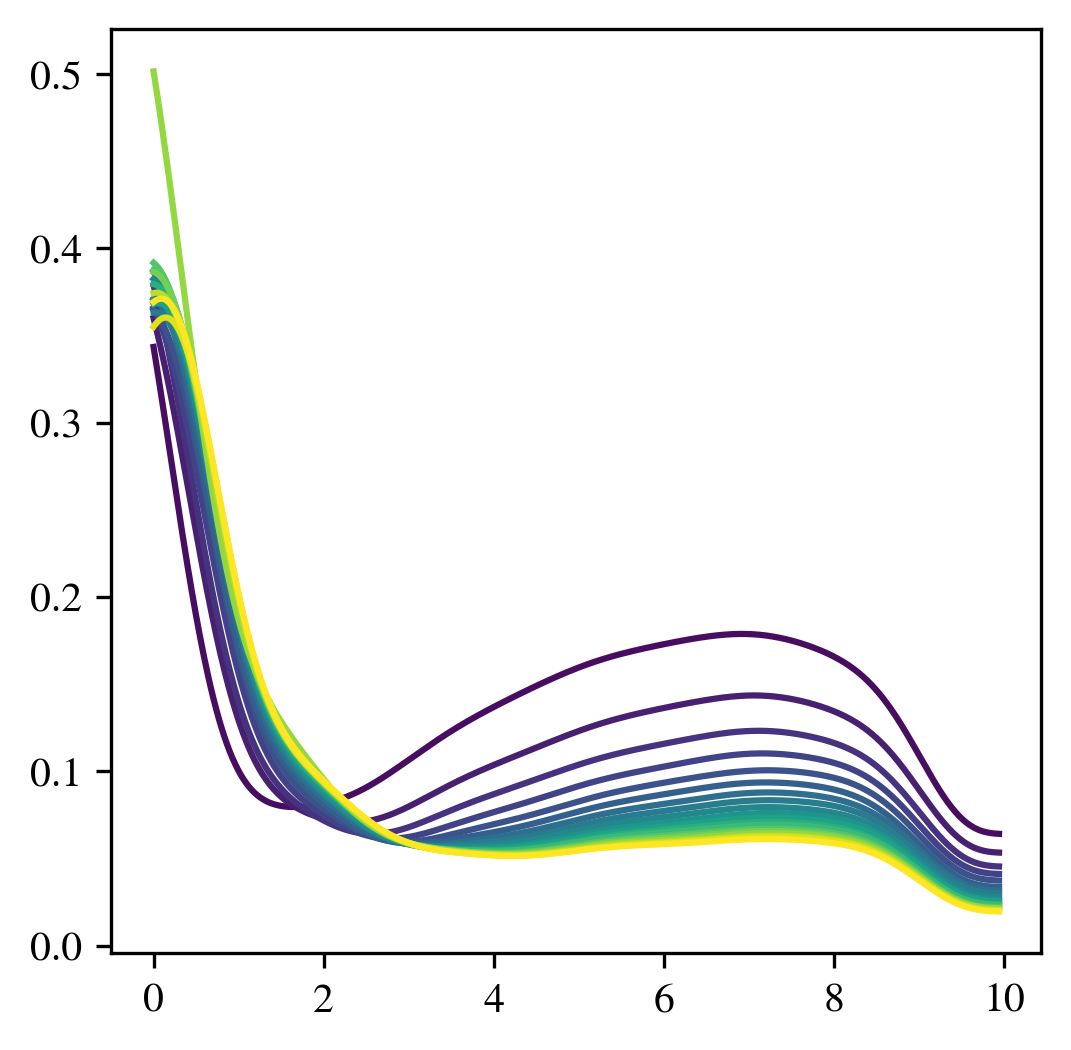

In [226]:
df = pd.read_csv(os.path.join(folder, "beet_juice_3_4.csv")).set_index("x")
# Design a Butterworth low-pass filter
order = 4
cutoff_frequency = 0.02  # Normalized cutoff frequency (0 to 0.5)
b, a = butter(order, cutoff_frequency, btype='low', analog=False)
# check if local minima exist in all columns
minima_list = []
maxima_list = []
tmax = float(df.columns[-1])
cmap = plt.get_cmap("viridis")
j = 0
fig, ax = plt.subplots(figsize=(4,4), dpi=300)
for kw in df:
    if j % 2 == 1:
        t = float(kw)
        x, y = df.index, df[kw]
        # plt.plot(x, y, color=cmap(float(kw)/tmax))

        # smooth the curve
        # Apply the filter to the data
        y_filtered = filtfilt(b, a, y)
        # Find local minima in the filtered data, exclude the first last points
        
        minima_indices = argrelextrema(y_filtered[exclude:-exclude], np.less)
        maxima_indices = argrelextrema(y_filtered[exclude:-exclude], np.greater)

        # plot the curves
        # ax.plot(x, y_filtered, color=cmap(float(kw)/tmax))
        # Plot the minima
        # if len(minima_indices[0]) > 0:
        #     ax.plot(t, y_filtered[minima_indices[0][0]+exclude], 'ro')
        # if len(maxima_indices[0]) > 0:
        #     ax.plot(t, y_filtered[maxima_indices[0][0]+exclude], 'go')
        # minima_list.append(len(minima_indices[0]))
        # maxima_list.append(len(maxima_indices[0]))
    j += 1

ValueError: Input data contains NaN or Inf values

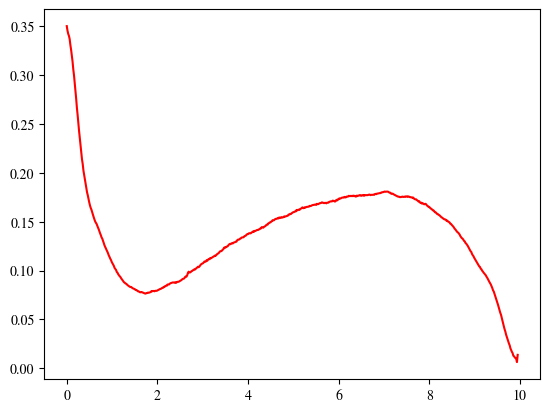

In [205]:
kw = df.columns[1]
x, y = df.index, df[kw]
plt.plot(x, y, color="red")
# Design a Butterworth low-pass filter
order = 3
cutoff_frequency = 0.3  # Normalized cutoff frequency (0 to 0.5)
b, a = butter(order, cutoff_frequency, btype='low', analog=False)
# Apply the filter to the data
# Check for NaN or Inf values in the data
if np.any(np.isnan(y)) or np.any(np.isinf(y)):
    raise ValueError("Input data contains NaN or Inf values")
y_filtered = filtfilt(b, a, y)
plt.plot(x, y_filtered, color="green")

## Appendix A. Load video

In [ ]:
cap = cv2.VideoCapture(r"E:\WPM\04292024\beet_scan_1.MOV")
while(cap.isOpened()):
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # by default opencv reads images as BGR, here we convert to RGB to be compatible with matplotlib
    break

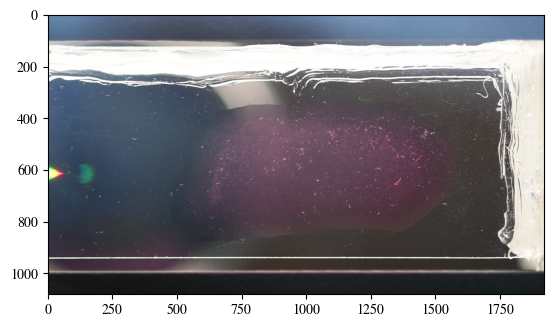

In [ ]:
plt.imshow(frame)

## Appendix B. Verify scanner speed

Since the scanner moves almost at a constant speed, a frame-by-frame tracking is an overkill. Instead, we can use two key frames at the beginning and the end of each scan, and infer the framewise location of the scanner, or the focus of the scanner. 

The key frame xy location is obtained from ImageJ and the frame number is obtained from MPC player (get time and convert to frame number).

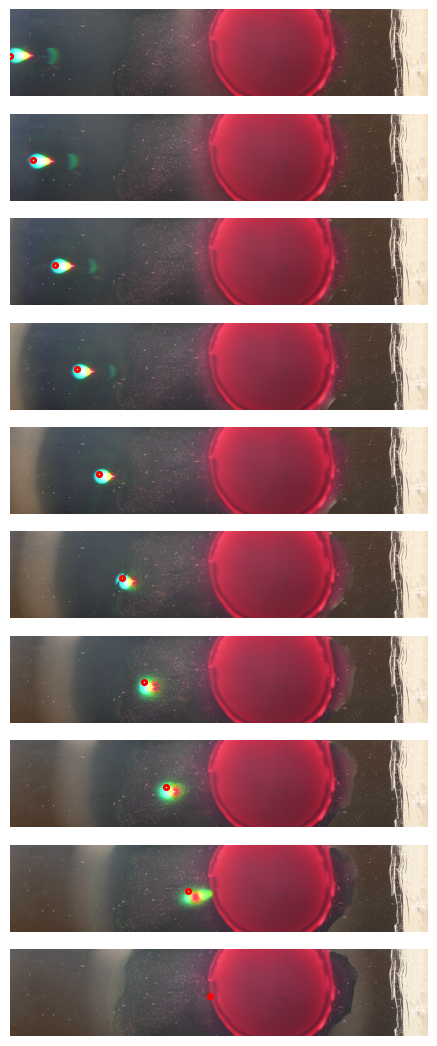

In [ ]:
# eye tracking 942@(1,614), 2099@(921,614)
# draw 10 pictures with dot indicator on raw image
cap = cv2.VideoCapture(r"E:\WPM\04292024\beet_scan_1.MOV")
i = 0
fps = 30
num_draw = 10
show = np.linspace(12.879*fps, 28.428*fps, endpoint=True, num=num_draw).astype("int")
x = np.linspace(1, 921, endpoint=True, num=num_draw)
y = np.ones(x.shape) * 614
count = 0
# initialize figure
fig, ax = plt.subplots(ncols=1, nrows=num_draw, figsize=(1980/300, 400*num_draw/300), dpi=100)
while True:
    ret, frame = cap.read()  
    if ret == False:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    i += 1
    if i in show:
        ax[count].imshow(frame[400:800, :])
        ax[count].scatter(x[count], y[count]-400, s=10, facecolor=(0,0,0,0), edgecolor="red", linewidths=2)
        ax[count].axis("off")
        count += 1

The scanner can be approximated as moving at a constant speed.

## Appendix C. Improve the setup

### C1. Faster scanner

To obtain more time resolved surface profile data, we use a step-motor-powered linear stage (from an old 3D printer) to replace the old thread linear stage. The new linear stage moves much faster, but also generates much more vibration which can make the surface measurement noisier. In this section, we plot the test measurement data and evaluate the effect of the vibration.  

(0.0, 145000.0)

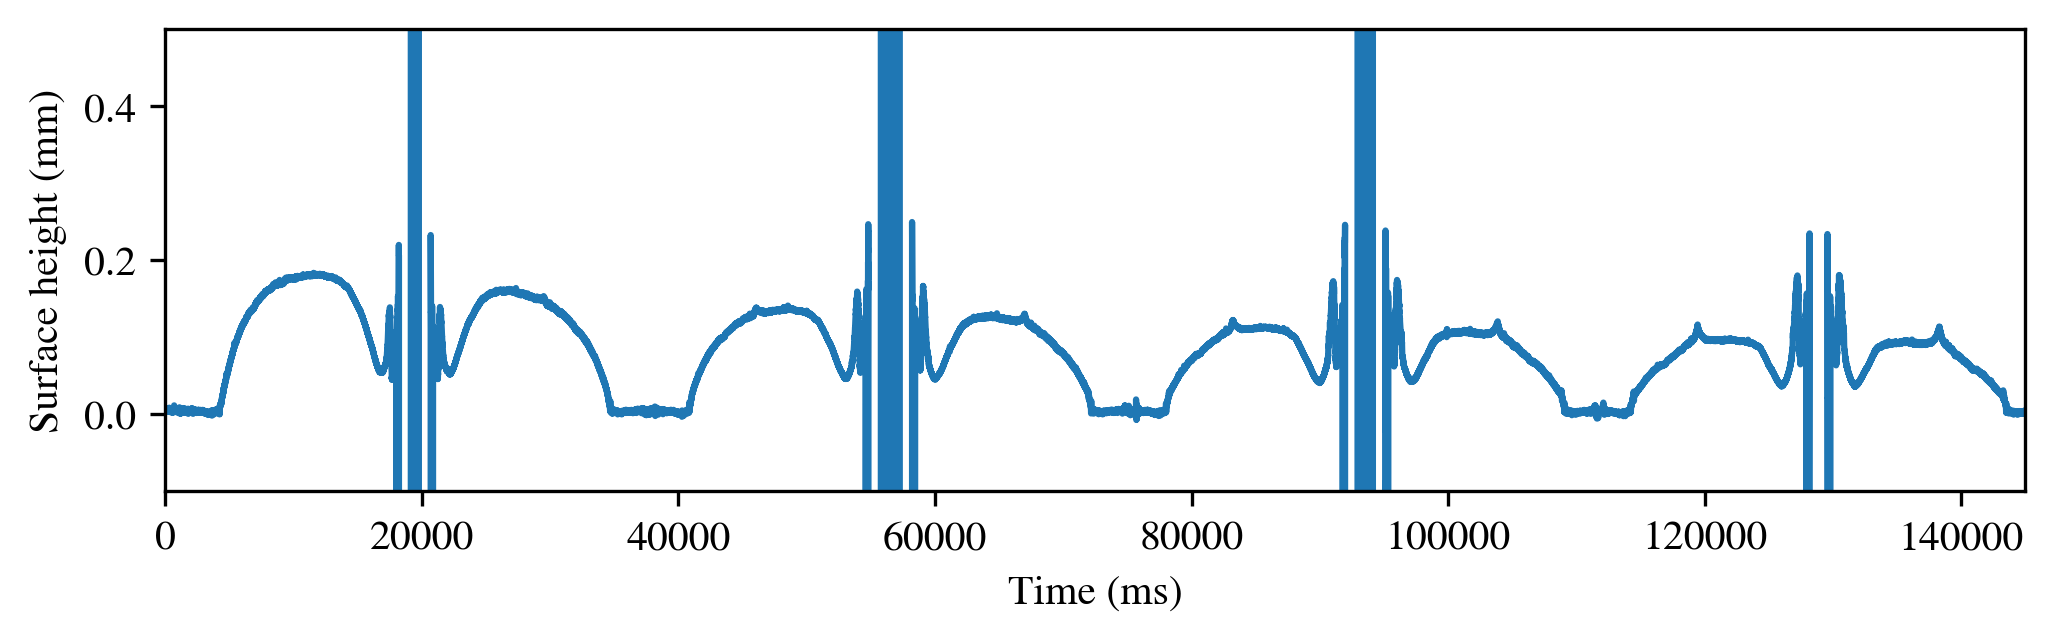

In [105]:
folder = r"E:\WPM\05012024"
filename = "beet_circle_full_sample1_4"
raw = pd.read_csv(os.path.join(folder, filename+".csv"), usecols=[1], skiprows=12)
plt.figure(figsize=(8, 2), dpi=300)
plt.plot(raw)
plt.xlabel("Time (ms)")
plt.ylabel("Surface height (mm)")
plt.ylim([-0.1, 0.5])
plt.xlim([0, 145000])

(-0.1, 0.5)

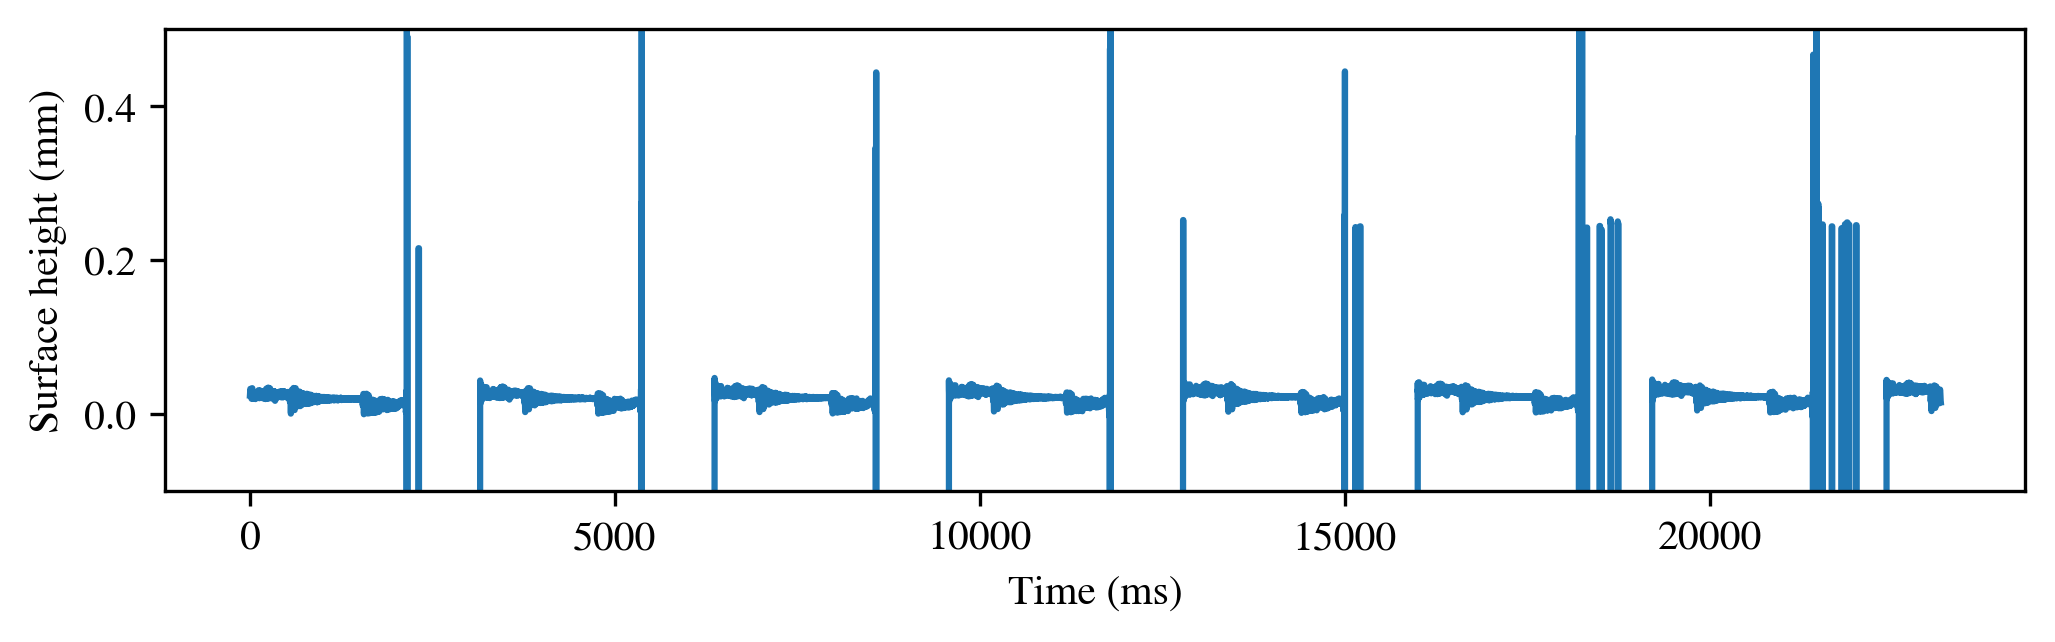

In [94]:
folder = r"E:\WPM\06062024"
filename = "stage_scan_flat_surface"
raw = pd.read_csv(os.path.join(folder, filename+".csv"), usecols=[1], skiprows=12)
plt.figure(figsize=(8, 2), dpi=300)
plt.plot(raw)
plt.xlabel("Time (ms)")
plt.ylabel("Surface height (mm)")
plt.ylim([-0.1, 0.5])
# plt.xlim([0, 25000])

(0.0, 15000.0)

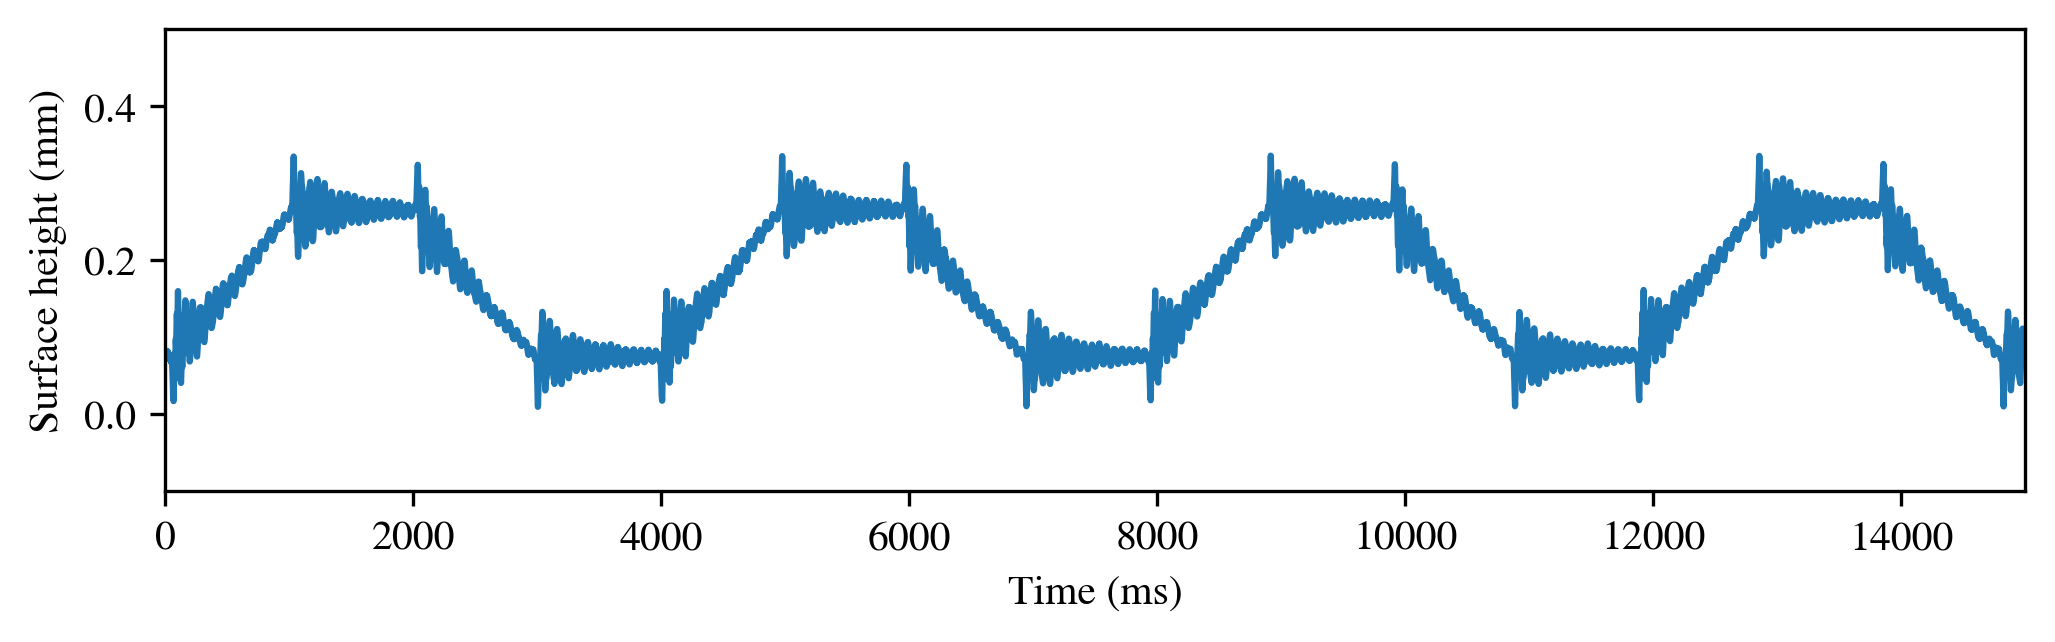

In [108]:
folder = r"E:\WPM\06112024"
filename = "scan_flat_surface_thread_stage_schneider"
raw = pd.read_csv(os.path.join(folder, filename+".csv"), usecols=[1], skiprows=53000)
plt.figure(figsize=(8, 2), dpi=300)
plt.plot(raw+0.2)
plt.xlabel("Time (ms)")
plt.ylabel("Surface height (mm)")
plt.ylim([-0.1, 0.5])
plt.xlim([0, 15000])

(0.0, 15000.0)

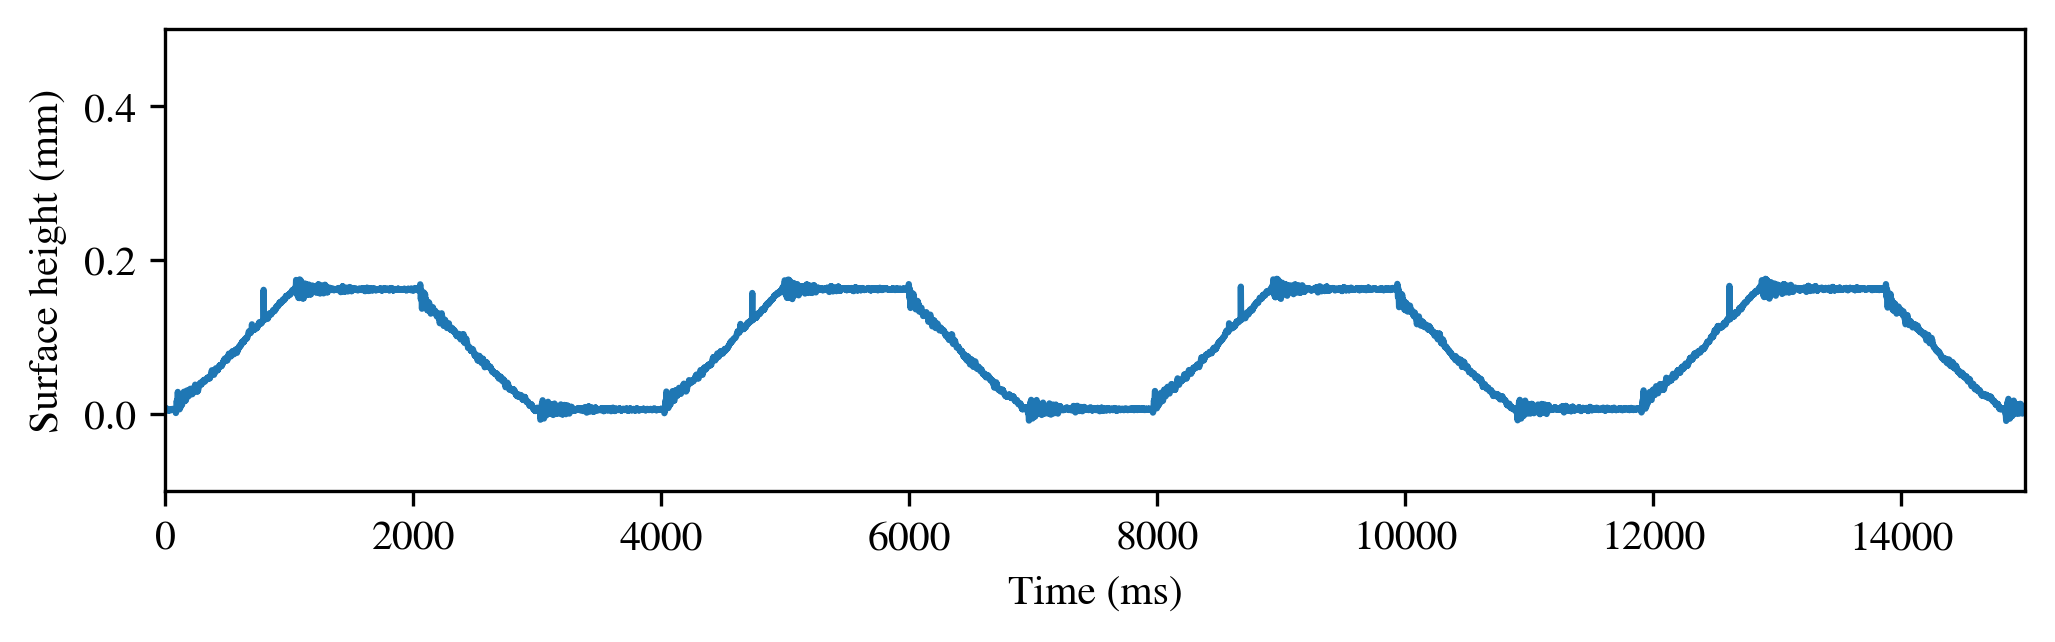

In [109]:
folder = r"E:\WPM\06122024"
filename = "scan_flat_surface_improved_stage_mount"
raw = pd.read_csv(os.path.join(folder, filename+".csv"), usecols=[1], skiprows=12)
plt.figure(figsize=(8, 2), dpi=300)
plt.plot(raw)
plt.xlabel("Time (ms)")
plt.ylabel("Surface height (mm)")
plt.ylim([-0.1, 0.5])
plt.xlim([0, 15000])

### C2. Compare scan quality

We have multiple setup designs already. An easy way to compare them is to compare the scan results on a flat surface. Below is a list of setup versions:

1. Zaber tube cylinder (slow)
2. Schneider linear stage (fast, small support beam, joint v1)
3. Schneider linear stage (fast, small support beam, joint v2)
4. Schneider linear stage (fast, large support beam, joint v3)
5. Schneider linear stage + sliding stage

With these setups, we scan a horizontal flat surface and compare the noise levels.

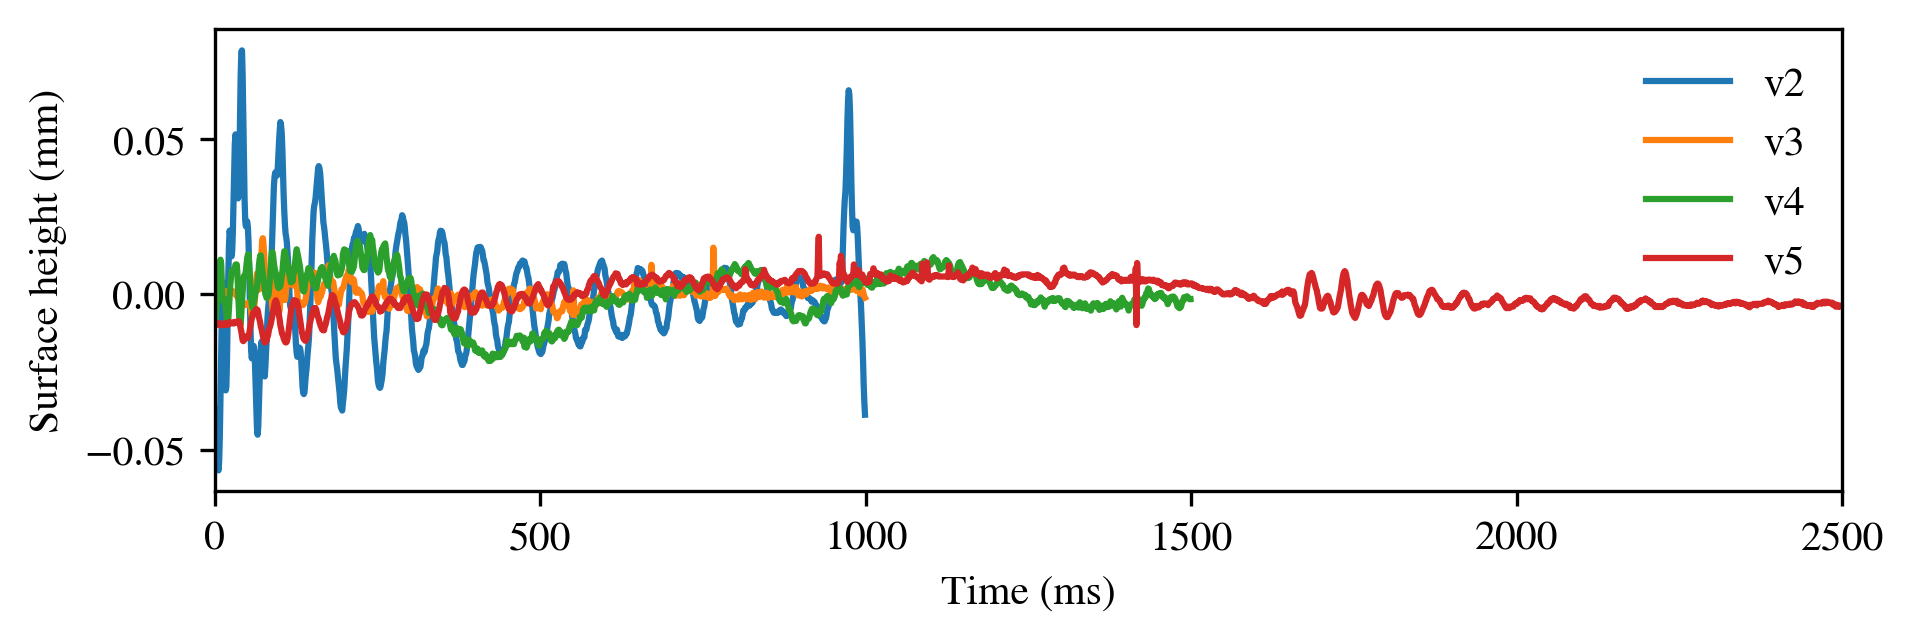

In [5]:
folder = r"E:\WPM\compare_setups"
l = readdata(folder, "csv")
fig, ax = plt.subplots(figsize=(7,2), dpi=300)
for num, i in l.iterrows():
    df = pd.read_csv(i.Dir)
    ax.plot(df.t, df.h, label=i.Name)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Surface height (mm)")
# plt.ylim([-0.1, 0.5])
plt.xlim([0, 2500])
ax.legend(frameon=False)

Text(0, 0.5, 'Surface height (mm)')

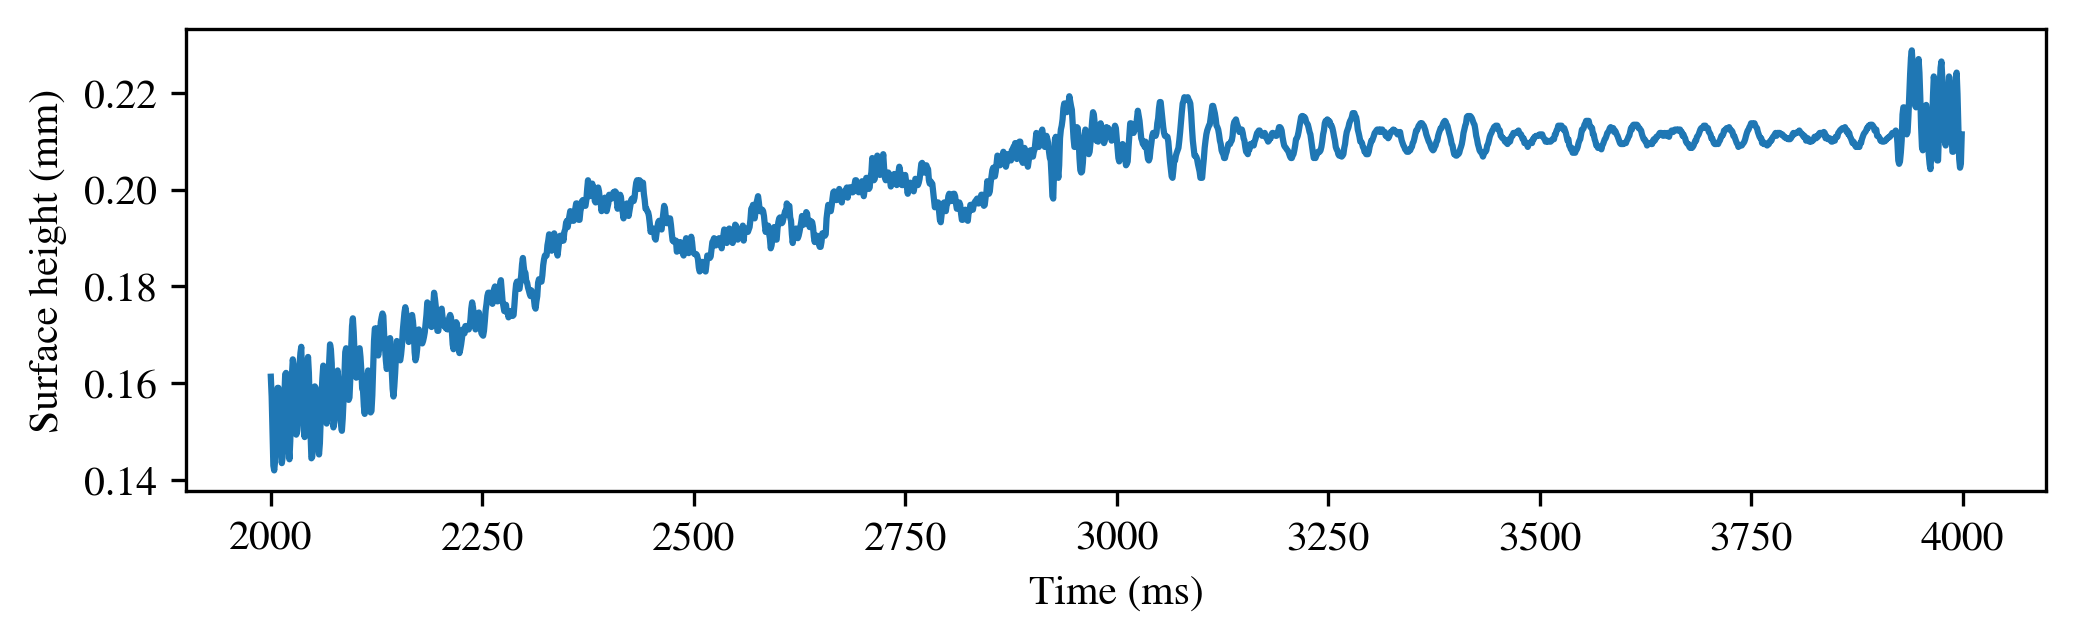

In [61]:
folder = r"E:\WPM\06122024"
filename = "beet_juice_2"
raw = pd.read_csv(os.path.join(folder, filename+".csv"), usecols=[1], skiprows=12)[2000:4000]
plt.figure(figsize=(8, 2), dpi=300)
plt.plot(raw)
plt.xlabel("Time (ms)")
plt.ylabel("Surface height (mm)")
# plt.ylim([-0.1, 0.5])
# plt.xlim([0, 15000])

### C3. Compare scan liquid film

In [52]:
df = {}
df["v1"] = pd.read_csv(r"E:\WPM\04292024\surface_profile\beet_scan4_4.csv")[["x", "scan-1"]].values
df["v3"] = pd.read_csv(r"E:\WPM\06212024\surface_profile\PB_S10_trial1_4.csv")[["x", "scan-50"]].values
df["v4"] = pd.read_csv(r"E:\WPM\08072024\surface_profile\beet_juice_1.csv")[["x", "scan-1"]].values

Text(0, 0.5, 'Surface height, $h$ (mm)')

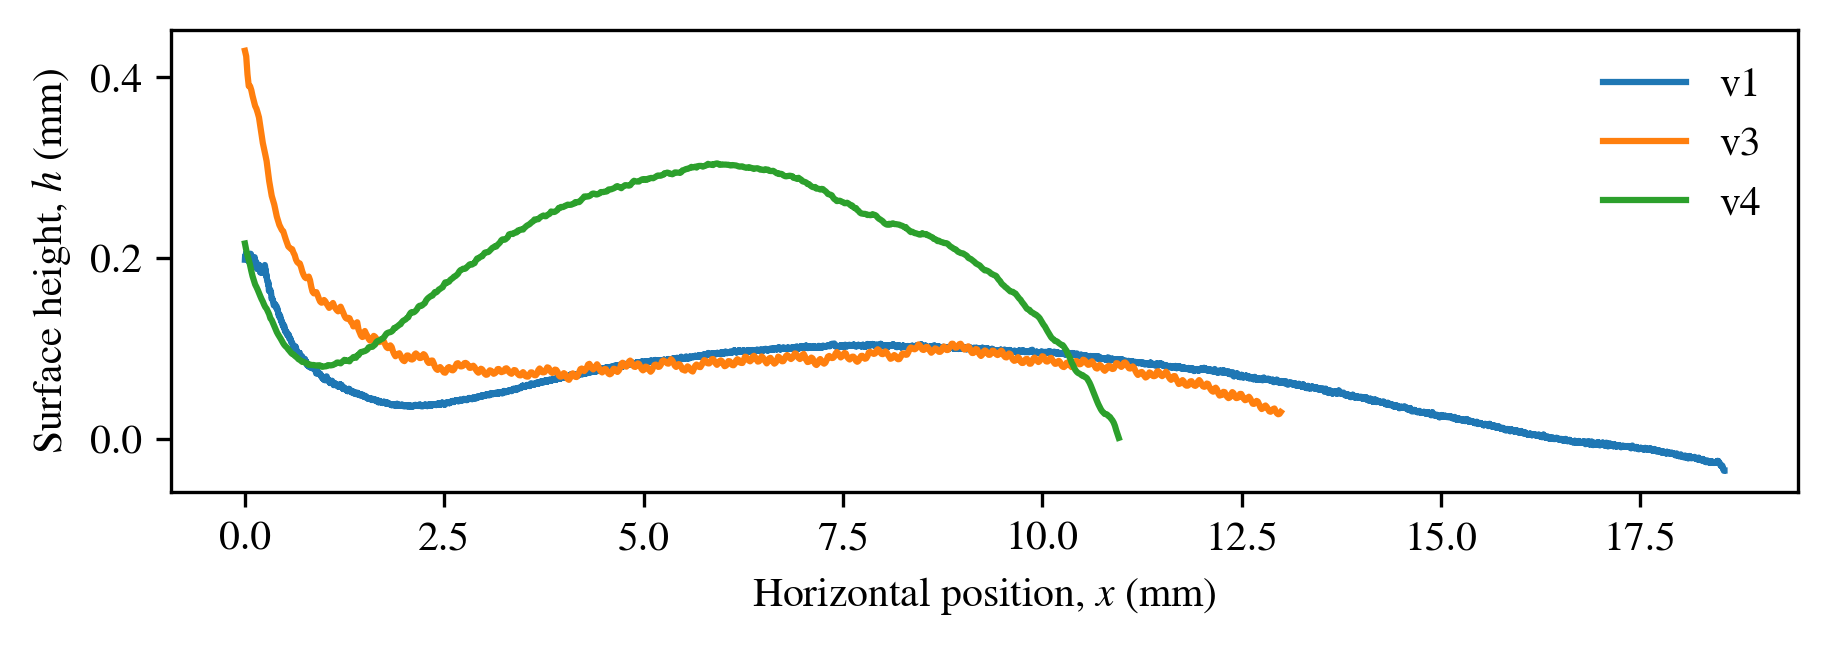

In [53]:
fig, ax = plt.subplots(figsize=(7,2), dpi=300)
for kw in df:
    ax.plot(df[kw][:, 0], df[kw][:, 1], label=kw)
ax.legend(frameon=False)
ax.set_xlabel("Horizontal position, $x$ (mm)")
ax.set_ylabel("Surface height, $h$ (mm)")

## Appendix D. Reynolds ridge?

Scott 1982 cited Satterly 1956 as an independent observation of Reynolds ridge. Is this true? Using the characteristic dependence of ridge-barrier distance on flow rate, we show that this fringe is different from Reynolds ridge. In this section, we plot fringe distance from barrier as a function of flow rate. The result is plotted together with the figure 2 of Mockros 1968, where distance increases when flow rate decreases.

In [5]:
stack = io.imread(r"E:\WPM\04252024\flow_09_cropped.tif")

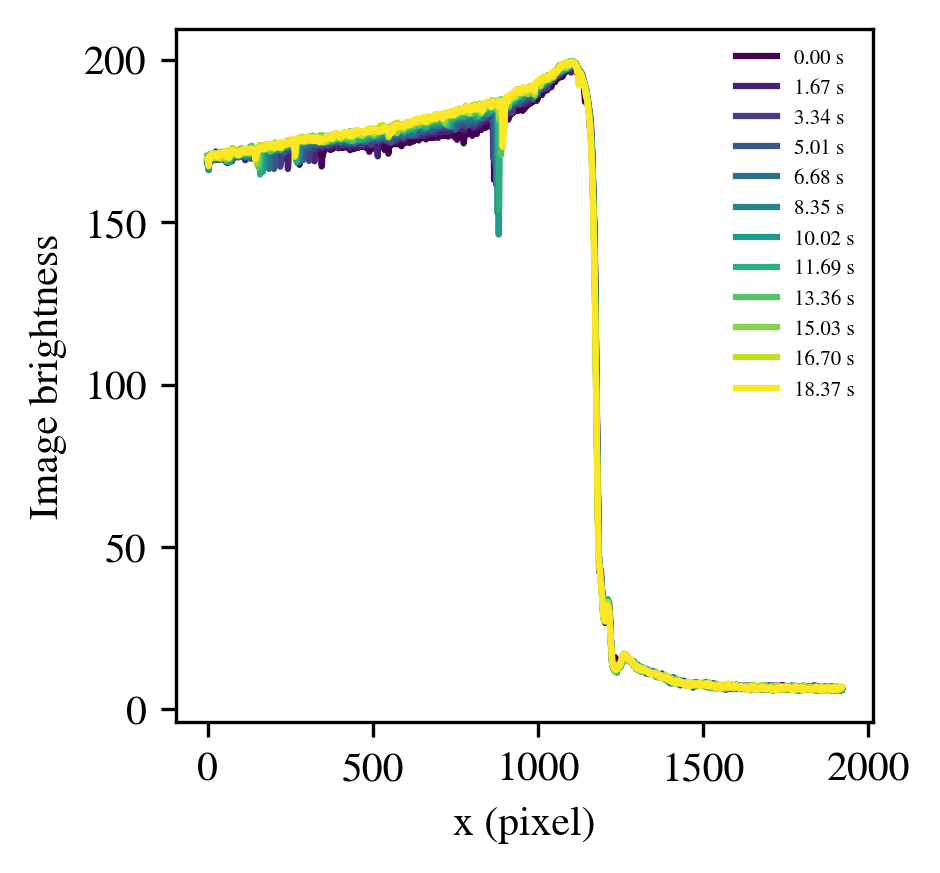

In [6]:
plt.figure(figsize=(3, 3), dpi=300)
cmap = plt.get_cmap("viridis", stack.shape[0])
i = 0
for img in stack:
    plt.plot(img[120:130, :].mean(axis=0), color=cmap(i), label="{:.2f} s".format(i*1.67))
    i += 1
plt.xlabel("x (pixel)")
plt.ylabel("Image brightness")
plt.legend(frameon=False, fontsize=5)

## Appendix E. Double check the surface profile cropping

With the fast scanner, we obtain more time-resolved surface profiles and understand the dimple formation better. However, cropping the actual surface profile from those out-of-range noise gets harder due to the increase of the amount of work. By assuming that the scanner always move in a strictly periodic way, we can label only a few keyframes and infer the rest. This approach makes the cropping faster, but also shows some inaccuracy that needs to be addressed. In this section, I double check all the cropped data and make corrections if needed.

(0.0, 0.8)

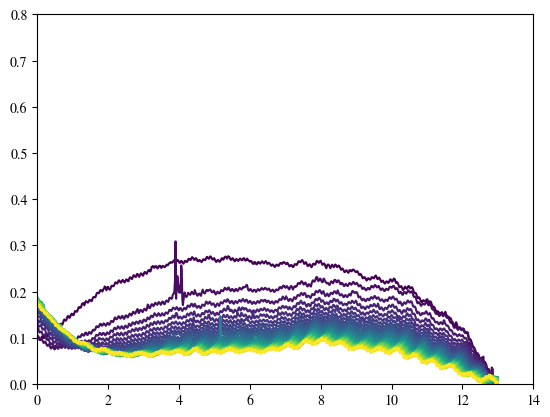

In [169]:
folder = r"G:\My Drive\Research projects\WPM\Data\06212024\surface_profile"
df = pd.read_csv(os.path.join(folder, "PB_S10_trial1_4.csv")).set_index("x")
i = 0
cmap = plt.get_cmap("viridis", df.shape[1])
for kw in df:
    if i % 2 == 0:
        plt.plot(df.index, df[kw], color=cmap(i))
    i += 1
    if i > 100:
        break
plt.xlim([0, 14])
plt.ylim([0, 0.8])

Besides the cropping issue, I also notice that the forward and backward scans show discrepancy. It looks like a slight tilt of the substrate. A good thing to do now is to only use one of the scans, either forward or backward.

In [12]:
folder = r"G:\My Drive\Research projects\WPM\Data\04292024\surface_profile"
df = pd.read_csv(os.path.join(folder, "beet_scan4_4.csv")).set_index("x")

folder = r"G:\My Drive\Research projects\WPM\Data\06212024\surface_profile"
df_w = pd.read_csv(os.path.join(folder, "PB_S10_trial1_4.csv")).set_index("x")

(0.0, 18.0, 0.0, 0.3)

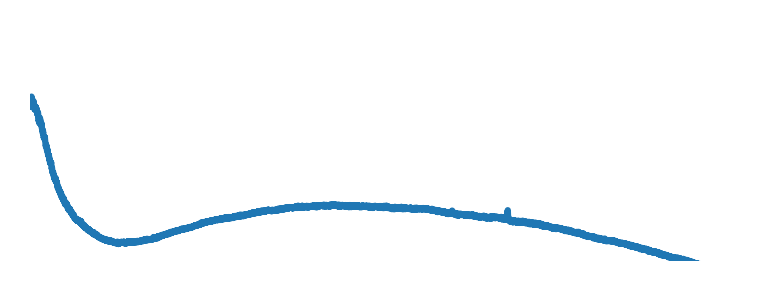

In [16]:
plt.figure(figsize=(3,1), dpi=300)
plt.plot(df.index, df["scan-3"])
# plt.plot(df_w.index, df_w["scan-3"])
plt.xlim([0, 18])
plt.ylim([0, 0.3])
# plt.xlabel("Horizontal position, $x$ (mm)")
# plt.ylabel("Surface height, $h$ (mm)")
plt.axis("off")

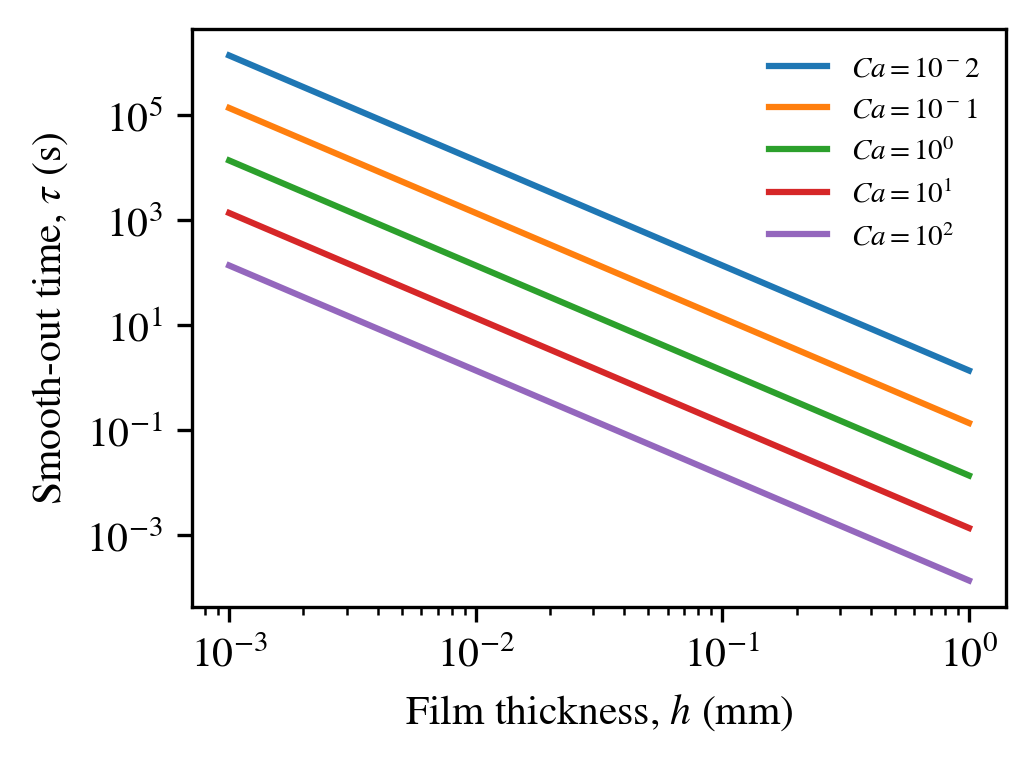

In [10]:
eta = 1e-3
L = 1e-2
gamma = 72e-3
h = np.logspace(-6, -3)

plt.figure(figsize=(3.5, 2.5), dpi=300)
for ca in [.01, .1, 1, 10, 100]:
    tau = eta * L**3 / ca / gamma / h**2
    plt.plot(h*1000, tau, label="$Ca=10^{0:d}$".format(int(np.log10(ca))))
plt.xlabel("Film thickness, $h$ (mm)")
plt.ylabel("Smooth-out time, $\\tau$ (s)")
plt.loglog()
plt.legend(fontsize=7, frameon=False)

## Appendix F. Linear stage is not straight?

In the stepper linear stage setup, we observe unexpected bumps in the scan results. Unlike the noise caused by motor vibration, the bumps are much lower frequency and the magnitude is less dependent on the motor frequency. We hypothesize that the bumps are not caused by the vibration of the setup, but the imperfection of the linear stage rod. To test this hypothesis, we measure a perfectly flat surface at two different motor frequency (delay time = 800 us or 3000 us). If the hypothesis is valid, we should see perfect match between the long wavelength bumps in the two scans.

In [49]:
s800 = pd.read_csv(r"E:\WPM\08072024\800delay.csv", usecols=[1], skiprows=12, names=["h"])
s3000 = pd.read_csv(r"E:\WPM\08072024\3000delay.csv", usecols=[1], skiprows=12, names=["h"])

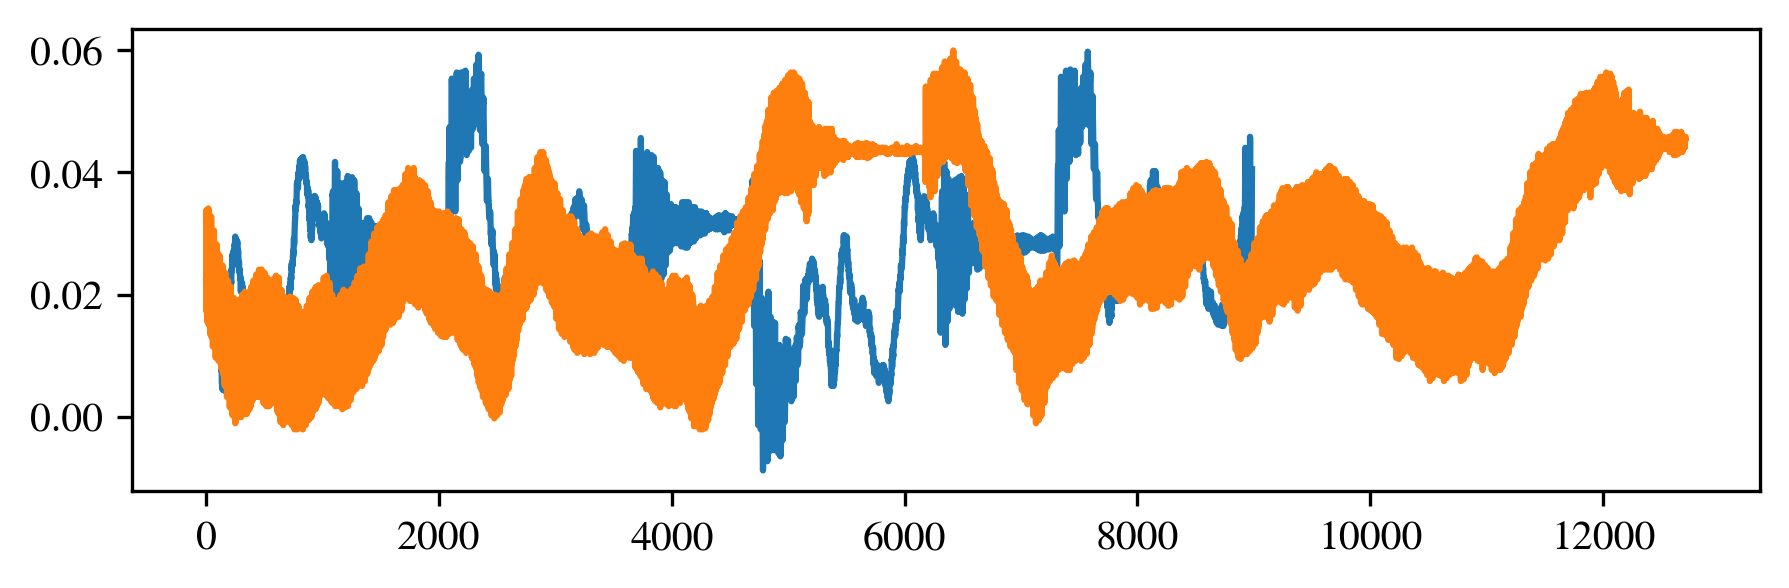

In [60]:
fig, ax = plt.subplots(figsize=(7,2), dpi=300)
ax.plot(s800.index, s800["h"])
ax.plot(s3000.index, s3000["h"])

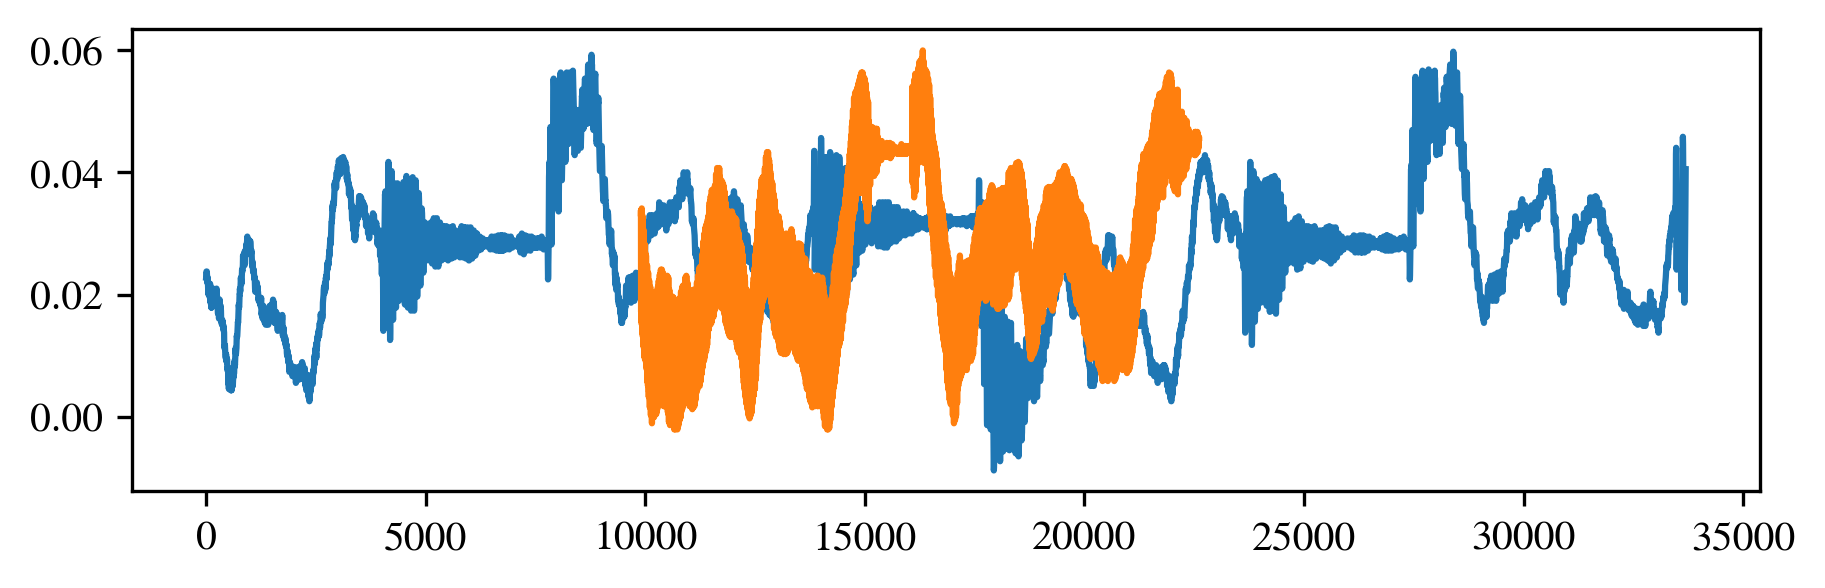

In [59]:

for i in range(100):
    fig, ax = plt.subplots(figsize=(7,2), dpi=300)
    ax.plot(s800.index*3000/800, s800["h"])
    ax.plot(i*100+s3000.index, s3000["h"])
    plt.pause(.1)
    clear_output(wait=True)
# ax.set_ylim([-0.1, 0.5])

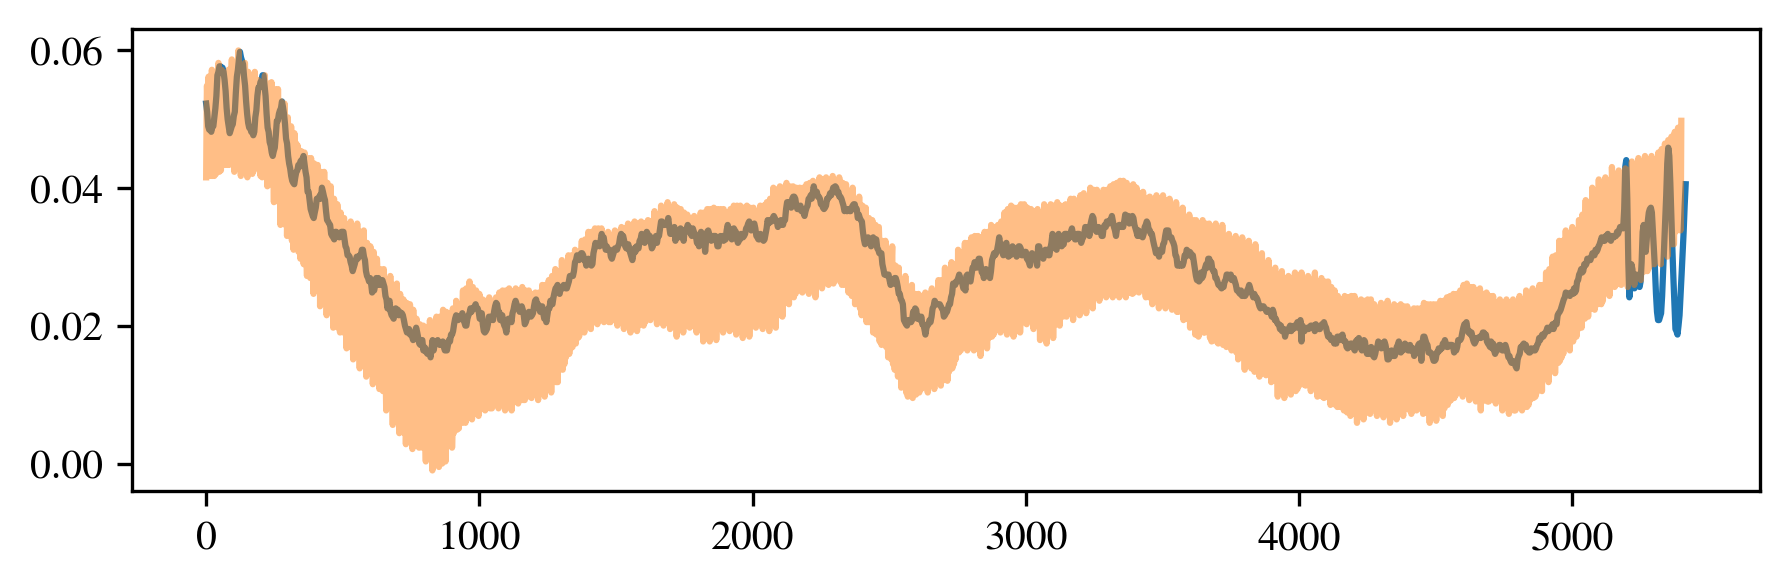

In [81]:
# try to match the features of the two scans
fig, ax = plt.subplots(figsize=(7,2), dpi=300)
s800c = s800[7540:].reset_index()
s3000c = s3000[6300:11700].reset_index()
ax.plot(s800c.index*3000/800, s800c["h"])
ax.plot(s3000c.index, s3000c["h"], alpha=.5)
# ax.set_ylim([-.1, .5])